The mean field $\alpha - \Omega $ dynamo equation in the kinematic regime,

$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}=  -\frac{\partial \alpha \bar{B}_\phi}{\partial z}+\eta_T\left( \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right]+ \frac{\partial^2 \bar{B}_r}{\partial z^2}\right), \\
& \frac{\partial \bar{B}_\phi}{\partial t}= -q\Omega \bar{B}_r+\eta_T \left(\frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] +\frac{\partial^2 \bar{B}_\phi}{\partial z^2}\right)\\
\end{aligned}
\end{aligned}
$$

Applying the no-z approximation,

$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}= - \frac{2}{\pi h}\alpha \bar{B}_\phi+\eta_T\left( \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] -  \frac{\pi^2}{4h^2} \bar{B}_r\right) , \\
& \frac{\partial \bar{B}_\phi}{\partial t}=r \frac{\partial\Omega}{\partial r}\bar{B}_r+\eta_T \left(\frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2}{4h^2} \bar{B}_\phi \right)\\
\end{aligned}
\end{aligned}
$$

Next, make them dimensionless to obtain the final equations to be solved,
$$
\begin{aligned}
&\begin{aligned}
& \frac{\partial \bar{B}_r}{\partial t}=- \frac{2}{\pi}\alpha \bar{B}_\phi+ \left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_r\right)\right] - \frac{\pi^2 \bar{B}_r}{4} , \\
& \frac{\partial \bar{B}_\phi}{\partial t}= r \frac{\partial\Omega}{\partial r}\bar{B}_r+\left(\frac{h_0}{R_0}\right)^2 \frac{\partial}{\partial r}\left[\frac{1}{r} \frac{\partial}{\partial r}\left(r \bar{B}_\phi\right)\right] - \frac{\pi^2 \bar{B}_\phi}{4}\\
\end{aligned}
\end{aligned}
$$




This file contains the same code as the other (report2.ipynb), just with boundary conditions included.

# Boundary Conditions
$$
B_r(0)= 0 =Br(R_0)\\

B_\phi(0)=0 = B_\phi(R_0)\\
$$

In [38]:
#Preliminaries and definitions

import numpy as np

#Typical lengthscales
h0=0.5 #kpc
R0=10 #kpc

#Grid
rmax=5
N_r=200
dr=rmax/(N_r-1)
r=np.linspace(0.001, rmax, N_r)

#Seed field
freq = 2  #Frequency of the sinusoidal function
amplitude = 1  # Amplitude of the sinusoidal function
noise_level = 0.2  # Level of random noise to add

# Different possible seed functions, choose a sine function
rand_sinfunc = amplitude * np.sin(2 * np.pi * freq * r/R0) #+ np.random.normal(scale=noise_level, size=N_r)
rand_cosfunc = amplitude * np.cos(2 * np.pi * freq * r/R0) #+ np.random.normal(scale=noise_level, size=N_r)

Br = rand_sinfunc
Bphi = rand_cosfunc

#Timesteps
tmax=30.0
N_t=1000
dt=tmax/N_t

#Dimensionless Omega and alpha
Omega0=5
Omega = Omega0/np.sqrt(1 + (r/R0)**2)

alpha0=[11.5,12,12.1,12.15,12.2,12.3,12.4,12.5,12.6,12.7,12.8]

#Define spatial derivatives
def cyl_laplacian_r(Bi):
    return (h0/R0)**2*np.gradient(np.gradient(r*Bi,dr)/r,dr)

def delrOmega(Omega):
    return np.gradient(Omega,dr)

#For each alpha0 (as defined in the list above), we get a value for D_c (as other parameters are not varied).
D=[alpha0[i]*r*delrOmega(Omega) for i in range(len(alpha0))]
print('Dynamo number D for each r (columns) and each alpha0 (rows): \n',D)
#In this code, alpha0 is used to keep track of D as Omega0 is not varied, and r del Omega/ del r is the same for the whole galaxy (its rotation curve).

#Define RK4
def RK4(dt,alpha,Br,Bphi):
    k1r = dt*(-2 * alpha / np.pi * Bphi + cyl_laplacian_r(Br) - Br*np.pi**2/4)
    k1phi = dt*(r * delrOmega(Omega) * Br + cyl_laplacian_r(Bphi) - Bphi*np.pi**2/4)

    k2r = dt*(-2 * alpha / np.pi * (Bphi + k1phi/2) + cyl_laplacian_r(Br + k1r/2) - (Br + k1r/2)*np.pi**2/4) 
    k2phi = dt*(r * delrOmega(Omega) * (Br + k1r/2) + cyl_laplacian_r(Bphi + k1phi/2) - (Bphi + k1phi/2)*np.pi**2/4)

    k3r = dt*(-2 * alpha / np.pi * (Bphi + k2phi/2) + cyl_laplacian_r(Br + k2r/2) - (Br + k2r/2)*np.pi**2/4)
    k3phi = dt*(r * delrOmega(Omega) * (Br + k2r/2) + cyl_laplacian_r(Bphi + k2phi/2) - (Bphi + k2phi/2)*np.pi**2/4)

    k4r = dt*(-2 * alpha / np.pi * (Bphi + k3phi) + cyl_laplacian_r(Br + k3r) - (Br + k3r)*np.pi**2/4)
    k4phi = dt*(r * delrOmega(Omega) * (Br + k3r) + cyl_laplacian_r(Bphi + k3phi) - (Bphi + k3phi)*np.pi**2/4)
    
    return Br + (k1r + 2*k2r + 2*k3r + k4r)/6, Bphi + (k1phi + 2*k2phi + 2*k3phi + k4phi)/6

Dynamo number D for each r (columns) and each alpha0 (rows): 
 [array([-7.79557398e-06, -3.92228204e-04, -1.50937950e-03, -3.35190189e-03,
       -5.91958612e-03, -9.21214061e-03, -1.32291916e-02, -1.79702830e-02,
       -2.34348768e-02, -2.96223531e-02, -3.65320101e-02, -4.41630645e-02,
       -5.25146514e-02, -6.15858249e-02, -7.13755580e-02, -8.18827428e-02,
       -9.31061911e-02, -1.05044634e-01, -1.17696724e-01, -1.31061033e-01,
       -1.45136052e-01, -1.59920197e-01, -1.75411802e-01, -1.91609124e-01,
       -2.08510343e-01, -2.26113561e-01, -2.44416802e-01, -2.63418016e-01,
       -2.83115075e-01, -3.03505777e-01, -3.24587843e-01, -3.46358922e-01,
       -3.68816588e-01, -3.91958342e-01, -4.15781611e-01, -4.40283751e-01,
       -4.65462047e-01, -4.91313712e-01, -5.17835888e-01, -5.45025650e-01,
       -5.72880002e-01, -6.01395880e-01, -6.30570152e-01, -6.60399620e-01,
       -6.90881019e-01, -7.22011020e-01, -7.53786228e-01, -7.86203183e-01,
       -8.19258364e-01, -8.52948188e

In [39]:
#Iterate through RK4 for different values of alpha0 (hence different values of D)

#Array to store all values
sol_array_Br=np.zeros((len(alpha0),N_t,N_r))
sol_array_Bphi=np.zeros((len(alpha0),N_t,N_r))

brcopy=Br
bphicopy=Bphi

for i in range(len(alpha0)):
    for t in range(N_t):
        Br[0]=0
        Br[-1]=0
        Bphi[0]=0
        Bphi[-1]=0
        sol_array_Br[i,t,:]=np.copy(Br)
        sol_array_Bphi[i,t,:]=np.copy(Bphi)
        Br,Bphi=RK4(dt,alpha0[i],Br,Bphi)
    Br=brcopy
    Bphi=bphicopy

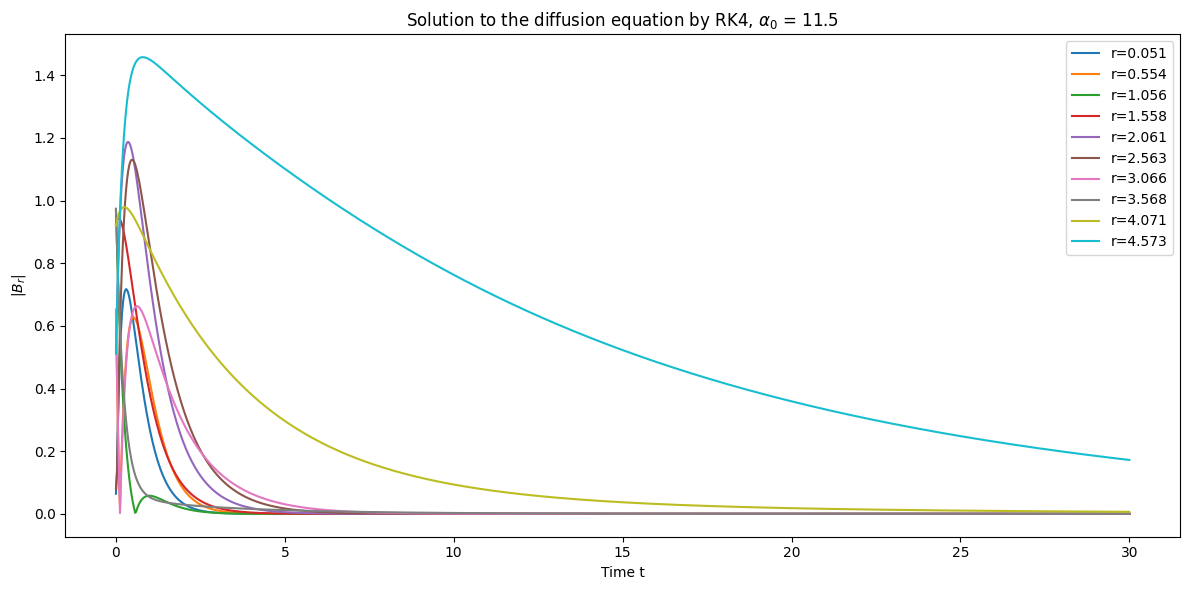

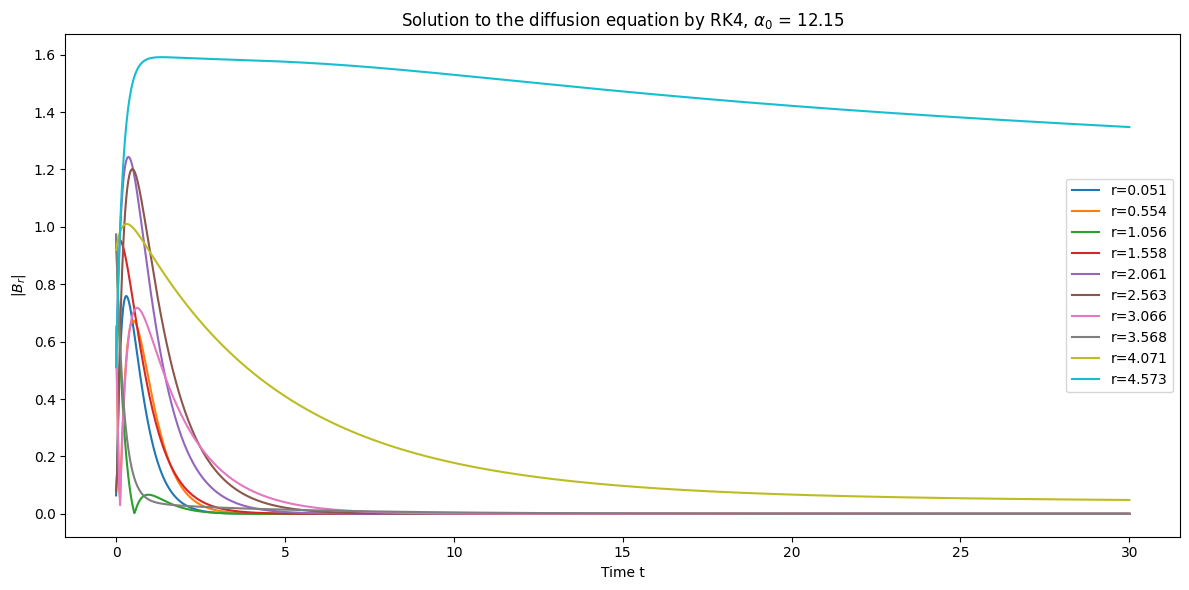

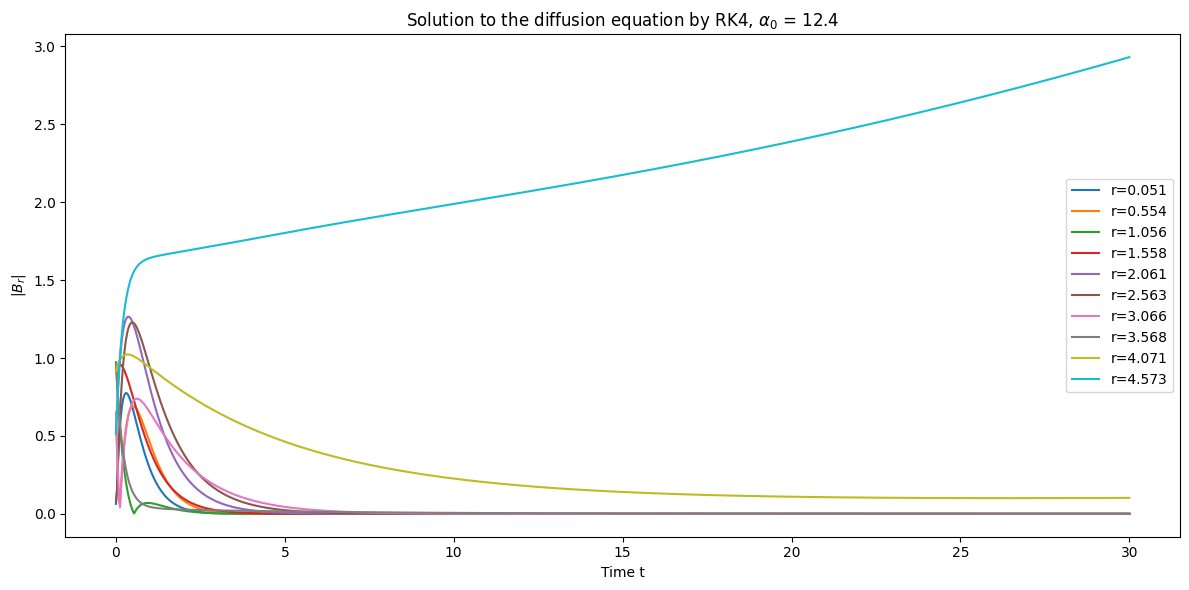

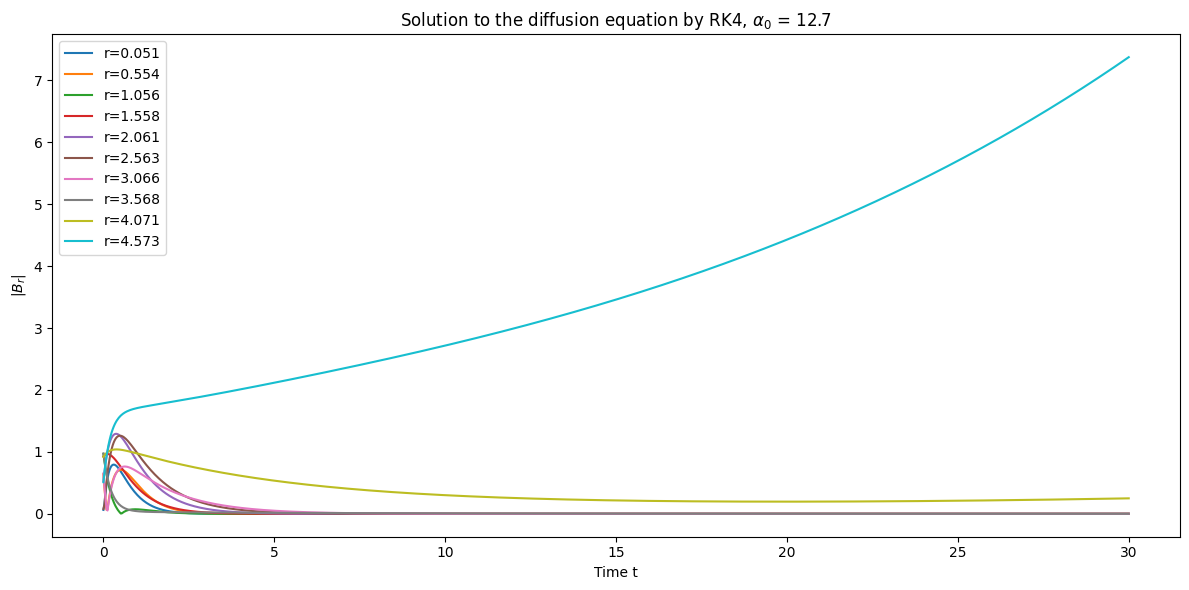

In [40]:
#Plot |B_r| vs. t for different alpha0 (hence different D)

from matplotlib import pyplot as plot
for i in range(0,len(alpha0),len(alpha0)//3):
    plot.figure(figsize=(12, 6))
    plot.plot(np.linspace(0, tmax, N_t), np.abs(sol_array_Br[i,:, 2::len(r)//10]))
    #plot.plot(np.linspace(0, tmax, N_t), np.abs(sol_array[:, [12,13,14,15,16]]))
    #plot.legend([f'r={r[i]:.3f}' for i in range(12,17)])
    plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
    plot.xlabel('Time t')
    plot.ylabel(r'$|B_r|$')
    plot.title(r"Solution to the diffusion equation by RK4, $\alpha_0$ = "+str(alpha0[i]))
    #if alpha0[i]>10:
    #    plot.xlim(5,10)
    #plot.ylim(0,.025)
    plot.tight_layout()
    plot.show()

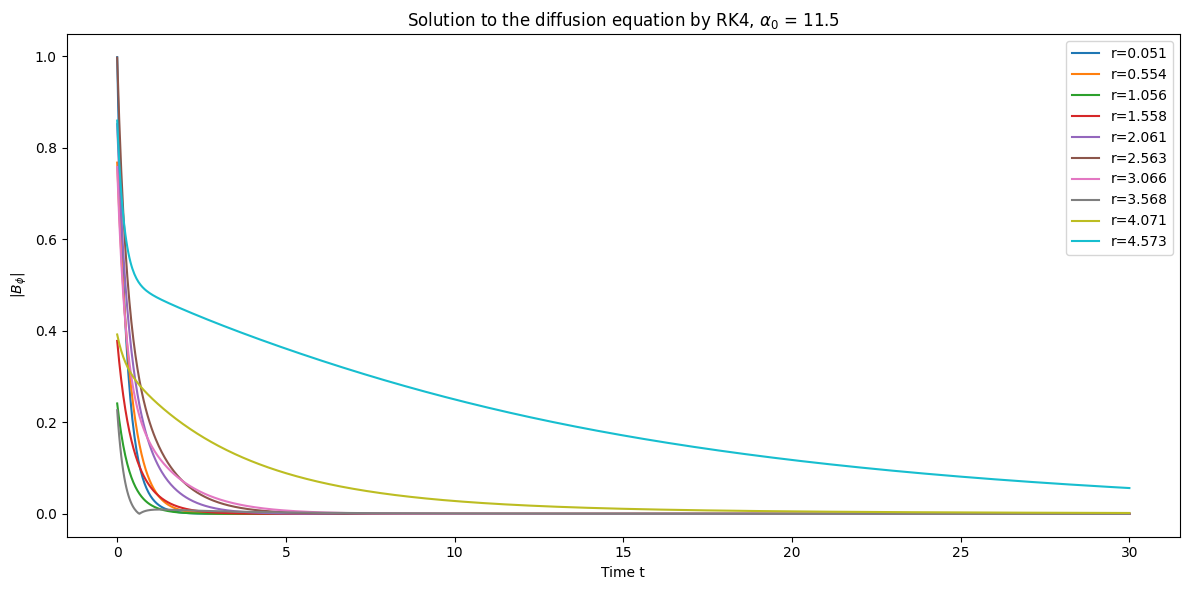

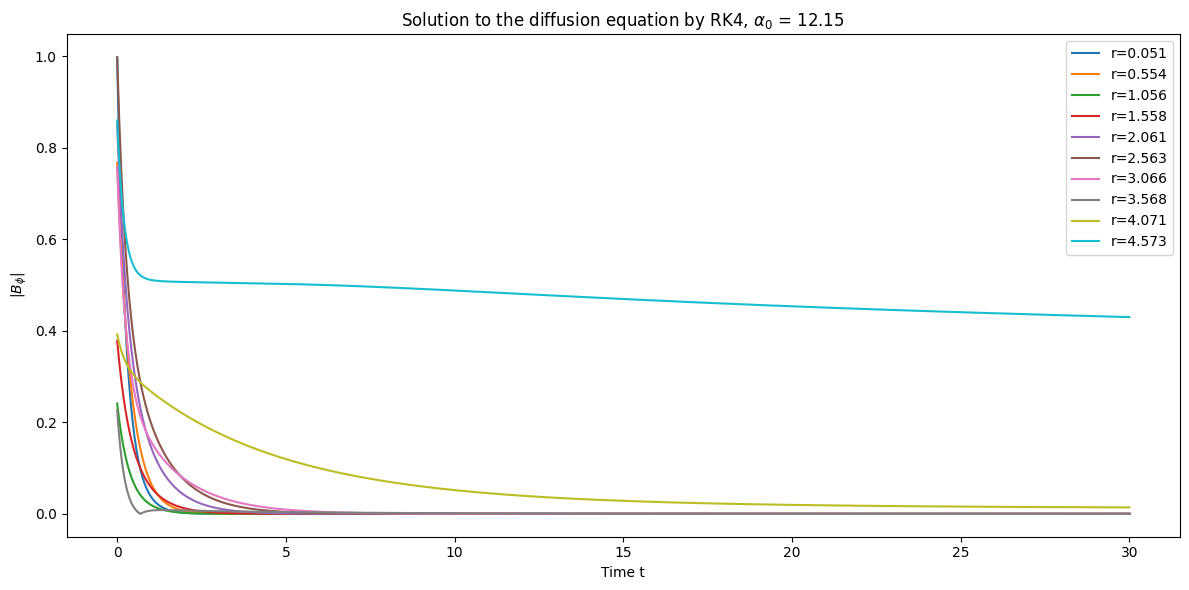

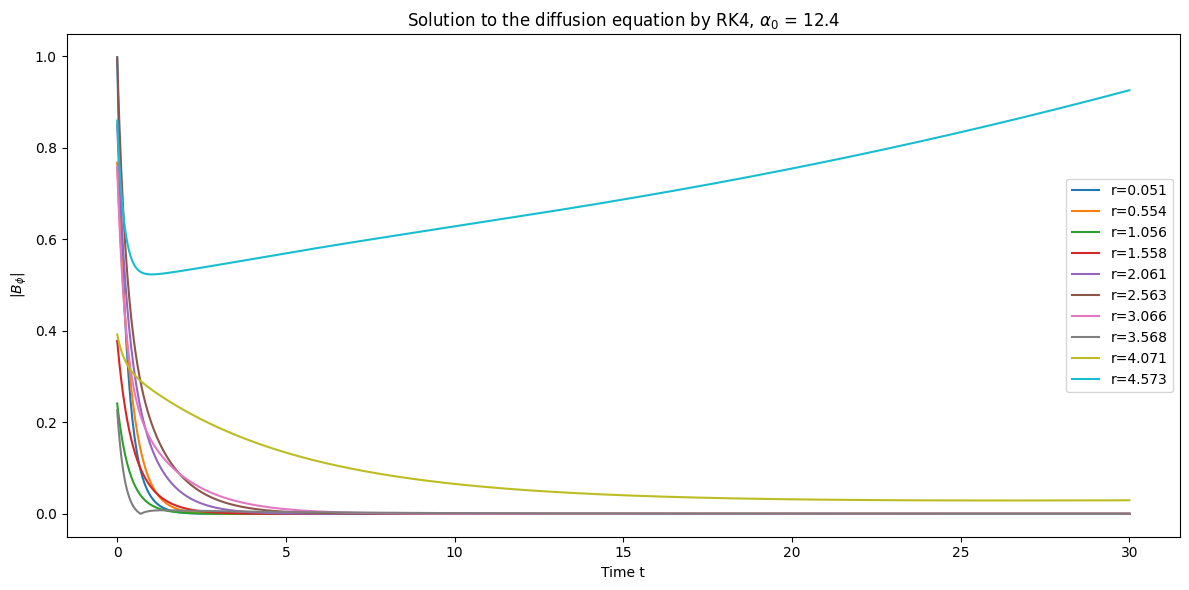

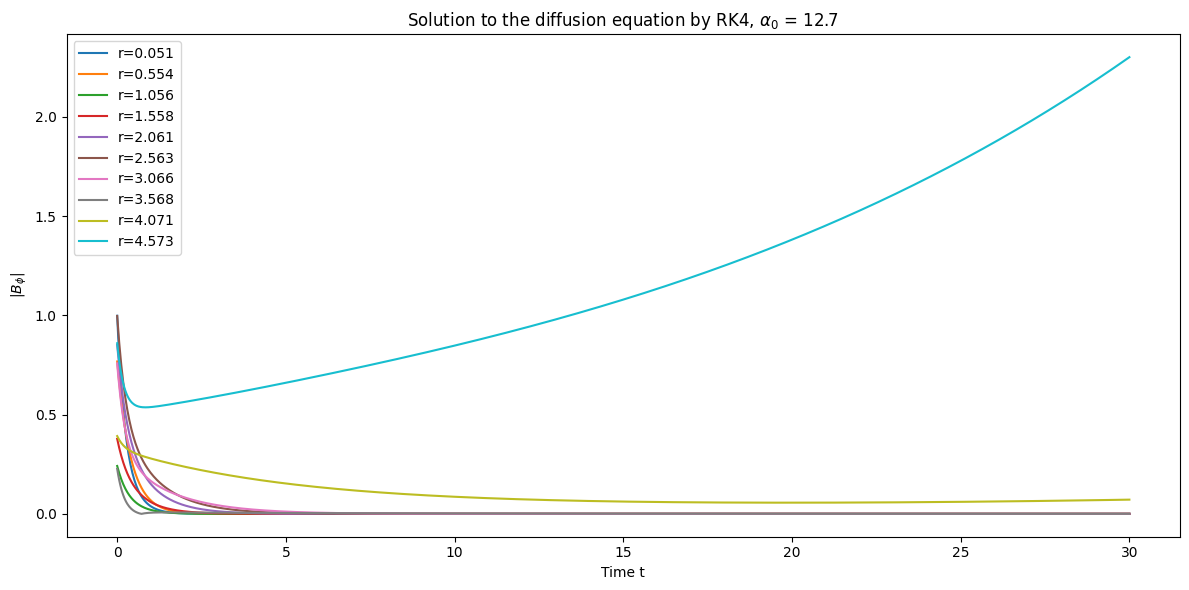

In [41]:
#Plot |B_phi| vs. t for different alpha0

for i in range(0,len(alpha0),len(alpha0)//3):
    plot.figure(figsize=(12, 6))
    plot.plot(np.linspace(0, tmax, N_t), np.abs(sol_array_Bphi[i,:, 2::len(r)//10]))
    plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
    plot.xlabel('Time t')
    plot.ylabel(r'$|B_\phi|$')
    plot.title(r"Solution to the diffusion equation by RK4, $\alpha_0$ = "+str(alpha0[i]))
    #plot.xlim(0,1.5)
    #plot.ylim(0,.025)
    plot.tight_layout()
    plot.show()

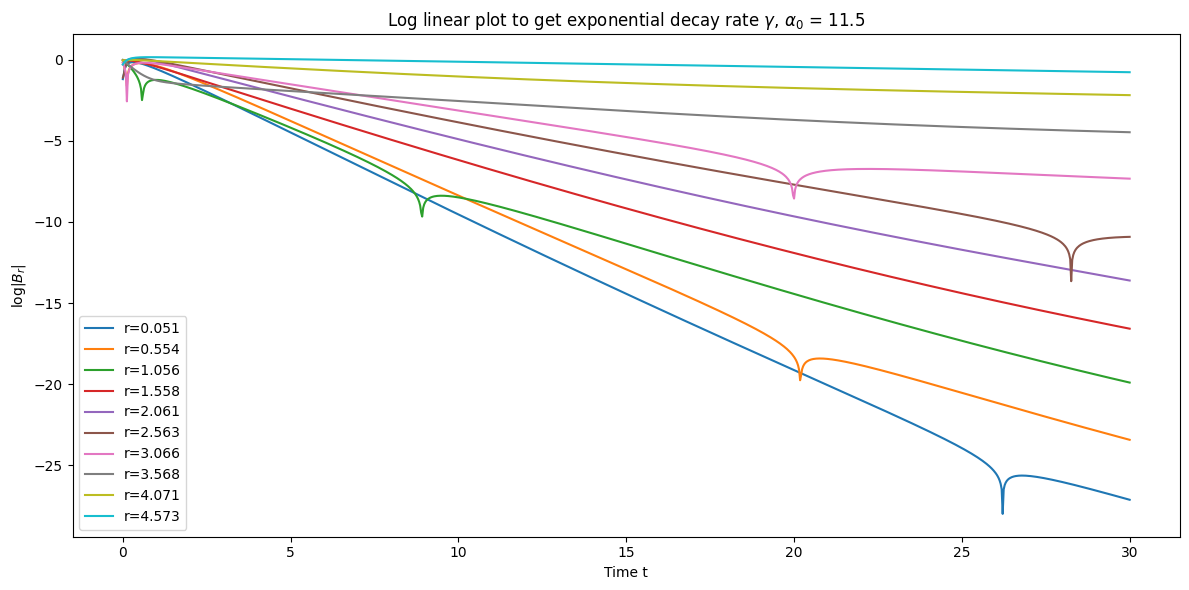

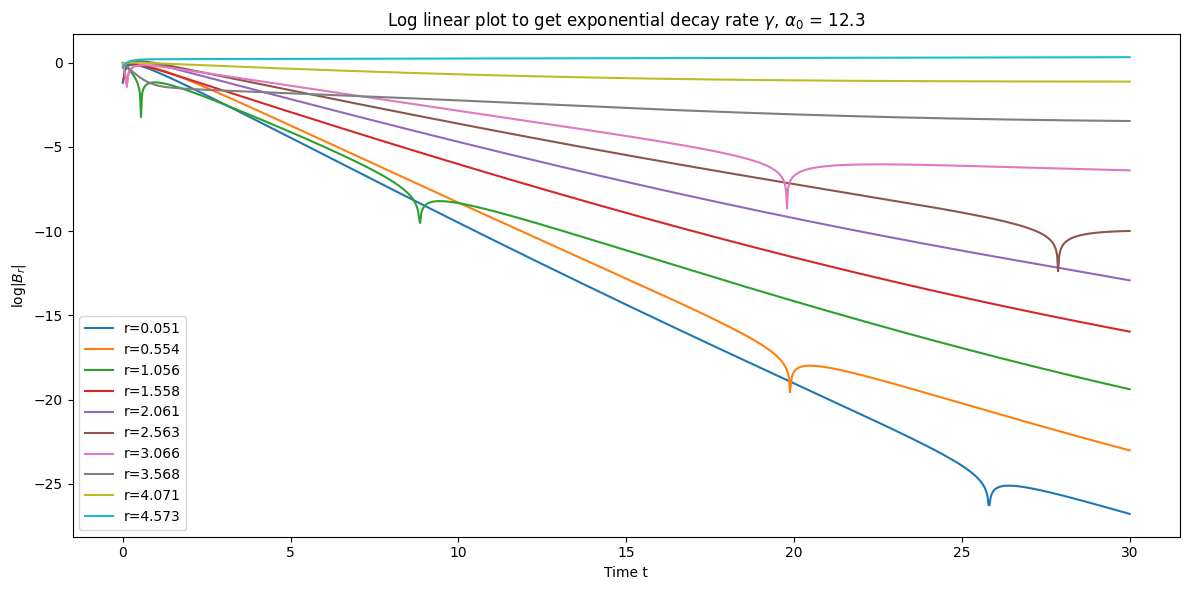

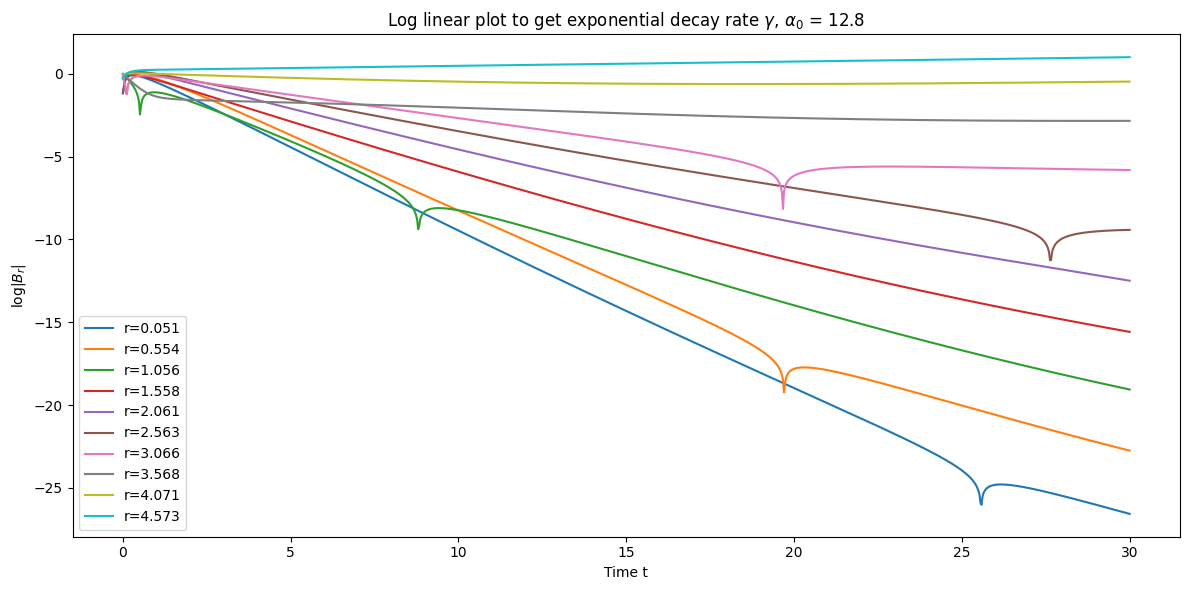

In [42]:
#Decay/Growth Rate of |B_r| vs. t for different alpha0

for i in range(0,len(alpha0),len(alpha0)//2):
    plot.figure(figsize=(12, 6))
    plot.plot(np.linspace(0, tmax, N_t), np.log10(np.abs(sol_array_Br[i, :, 2::len(r)//10])))
    plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
    plot.xlabel('Time t')
    plot.ylabel(r'log$|B_r|$')
    plot.title(r"Log linear plot to get exponential decay rate $\gamma$, $\alpha_0$ = "+f'{alpha0[i]}')
    plot.tight_layout()
    plot.show()

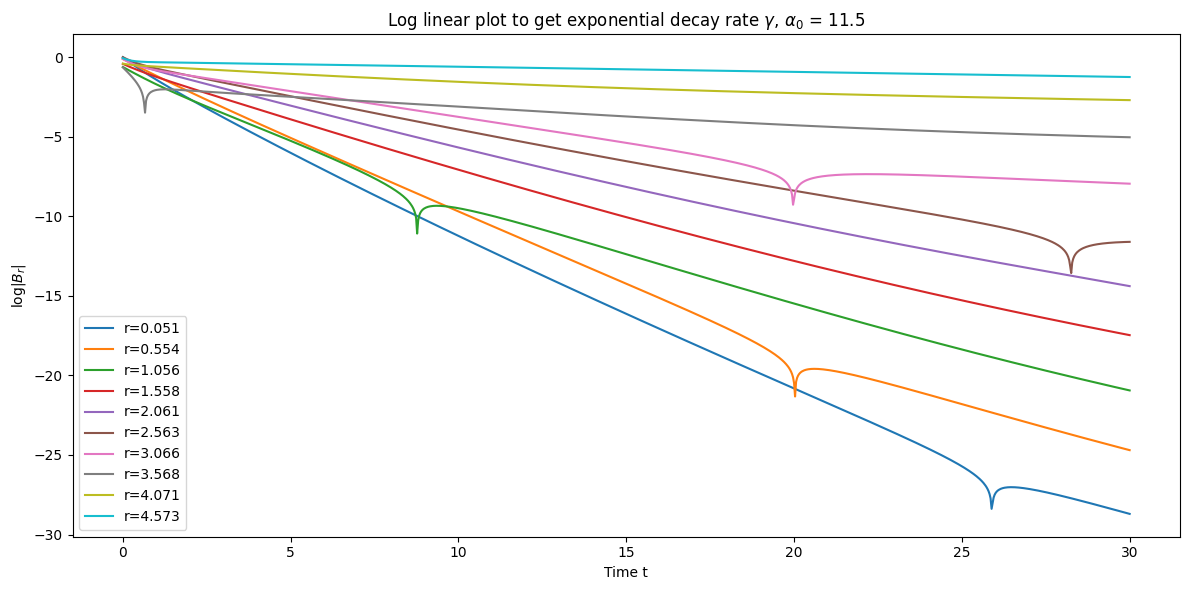

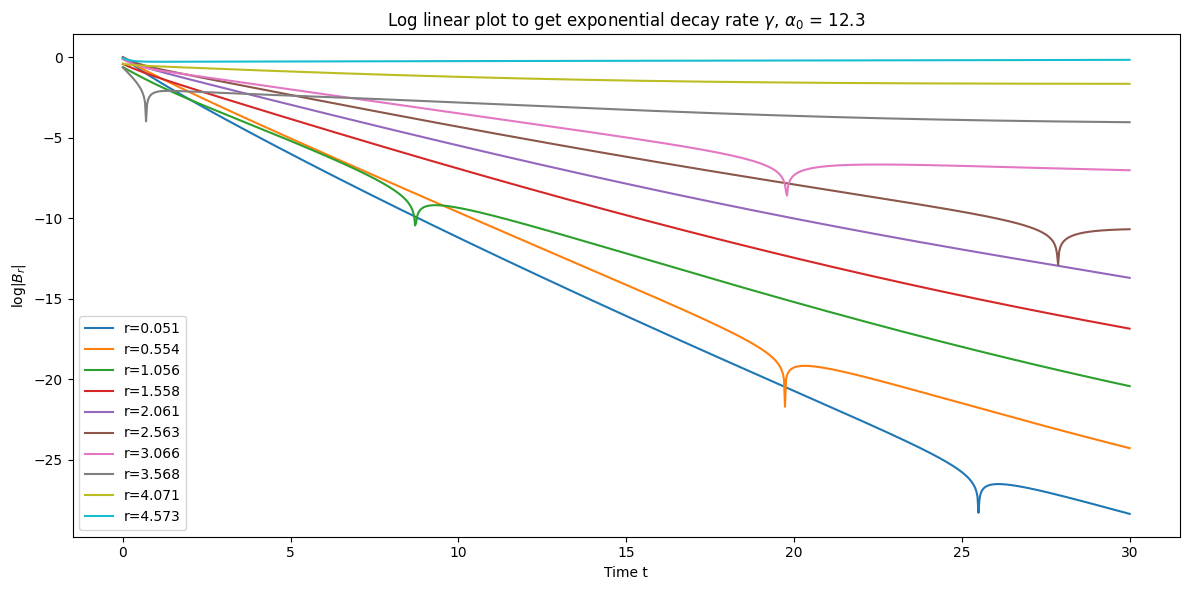

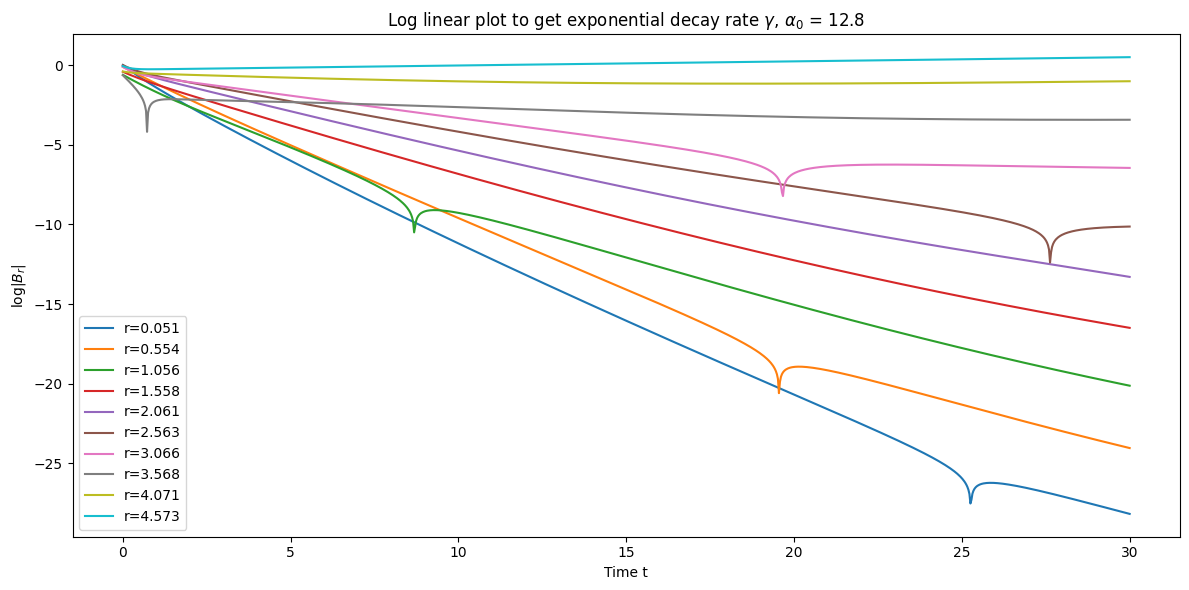

In [43]:
#Decay/Growth Rate of |B_phi| vs. t for different alpha0

for i in range(0,len(alpha0),len(alpha0)//2):
    plot.figure(figsize=(12, 6))
    plot.plot(np.linspace(0, tmax, N_t), np.log10(np.abs(sol_array_Bphi[i, :, 2::len(r)//10])))
    plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
    plot.xlabel('Time t')
    plot.ylabel(r'log$|B_r|$')
    plot.title(r"Log linear plot to get exponential decay rate $\gamma$, $\alpha_0$ = "+f'{alpha0[i]}')
    plot.tight_layout()
    plot.show()

The local growth/decay rate $\gamma$ is fluctuating more than desired. Hence, attempt to find the global growth rate Γ. For this we need average $B$. It is found by calculating $\sqrt{B_r^2 + B_{\phi}^2}$ for each $r$, and then averaging over $r$. Thus, we get an average $B$ for each timestep.

In [44]:
B_av_t = np.zeros((len(alpha0), N_t))
b_av_r = np.zeros(len(r))

#Find average B
for i in range(len(alpha0)):
    for t in range(N_t):
        for j in range(len(r)):
            b_av_r[j] = np.sqrt(  (sol_array_Br[i,t,j])**2 + (sol_array_Bphi[i,t,j])**2  )
        B_av_t[i,t] = np.average(b_av_r)


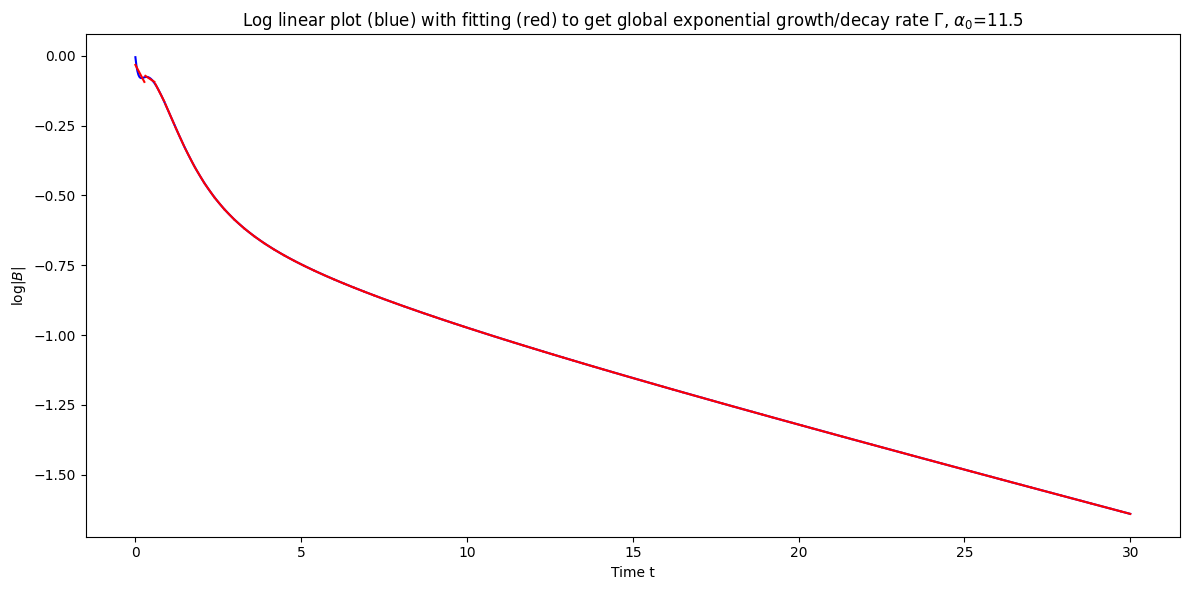

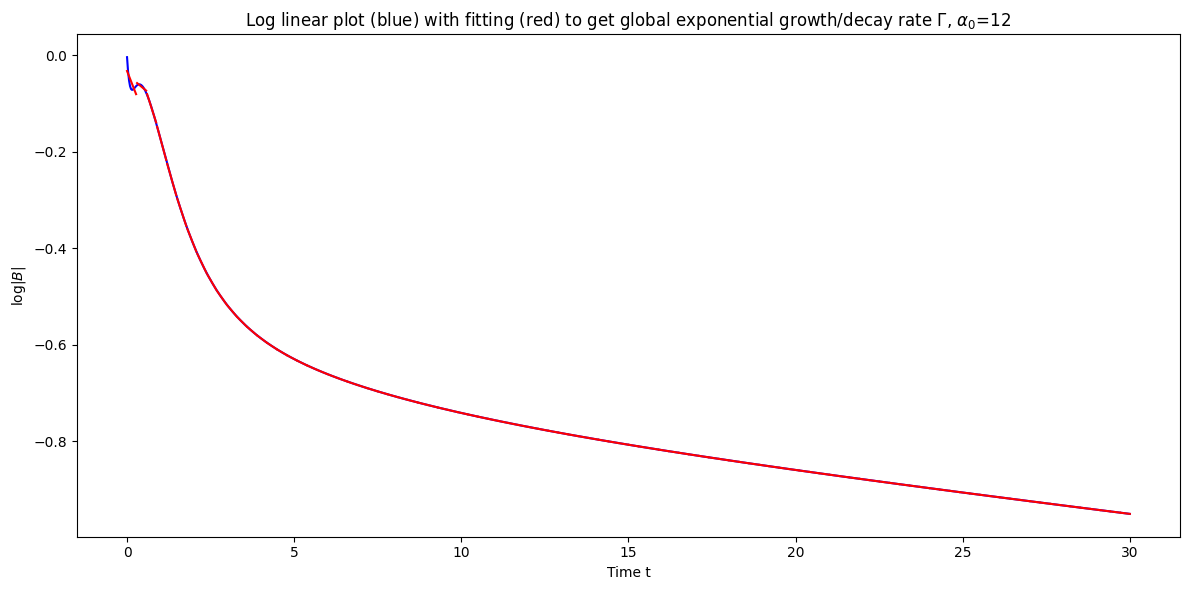

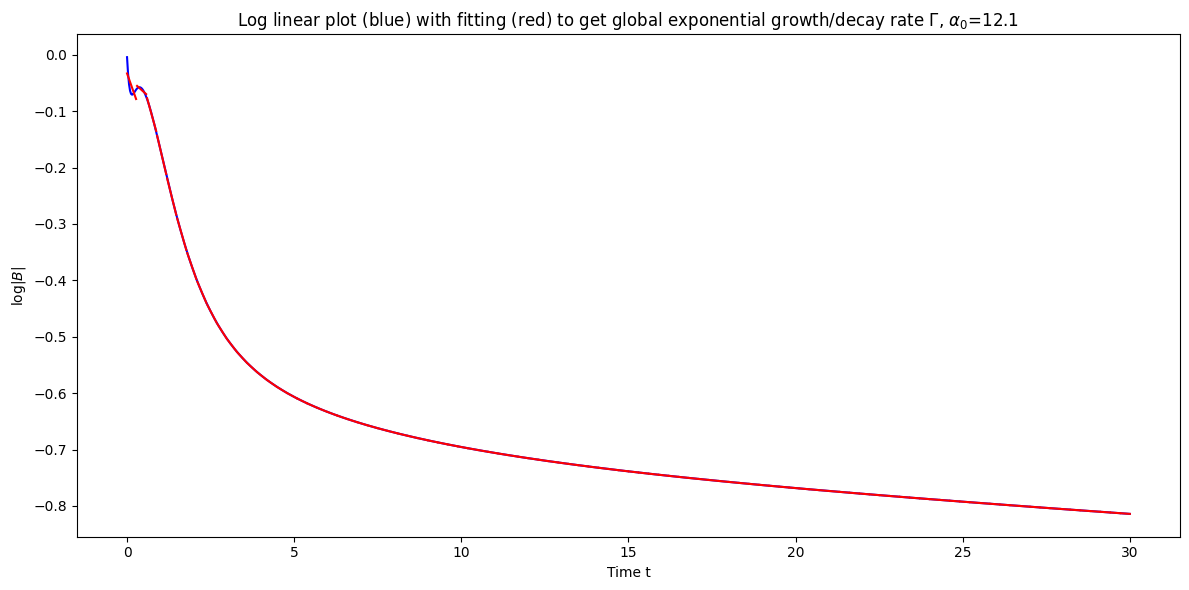

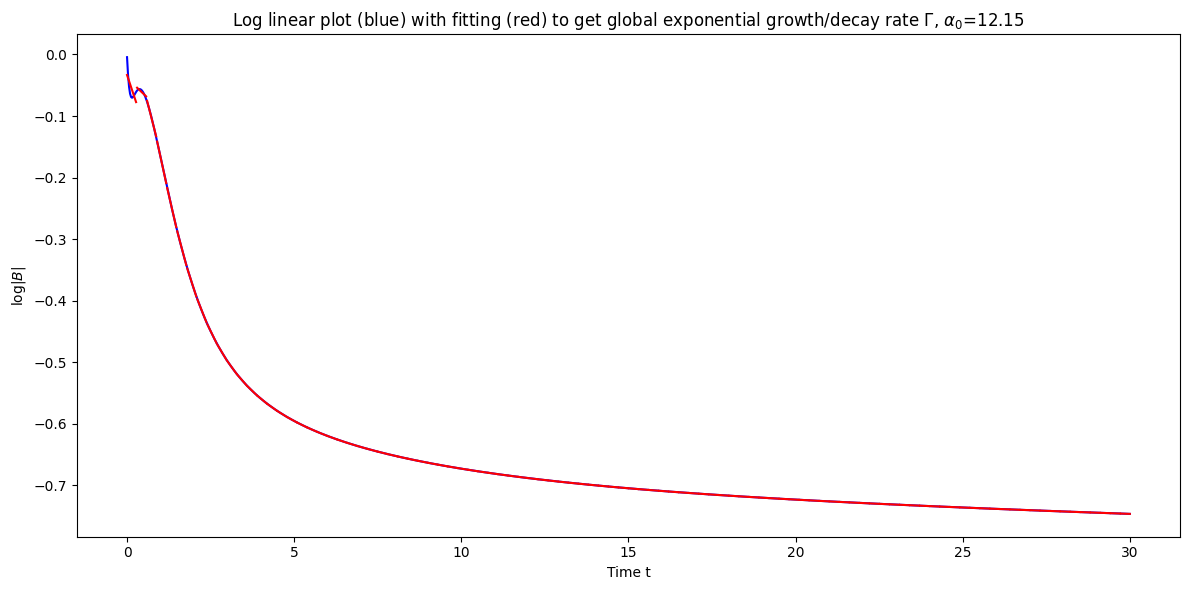

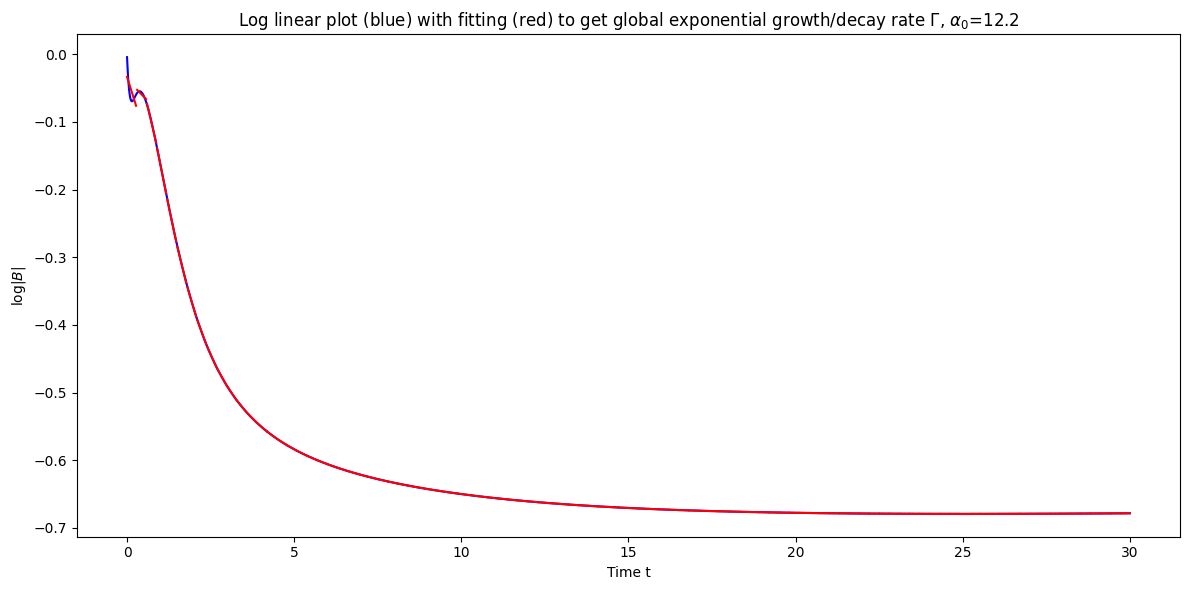

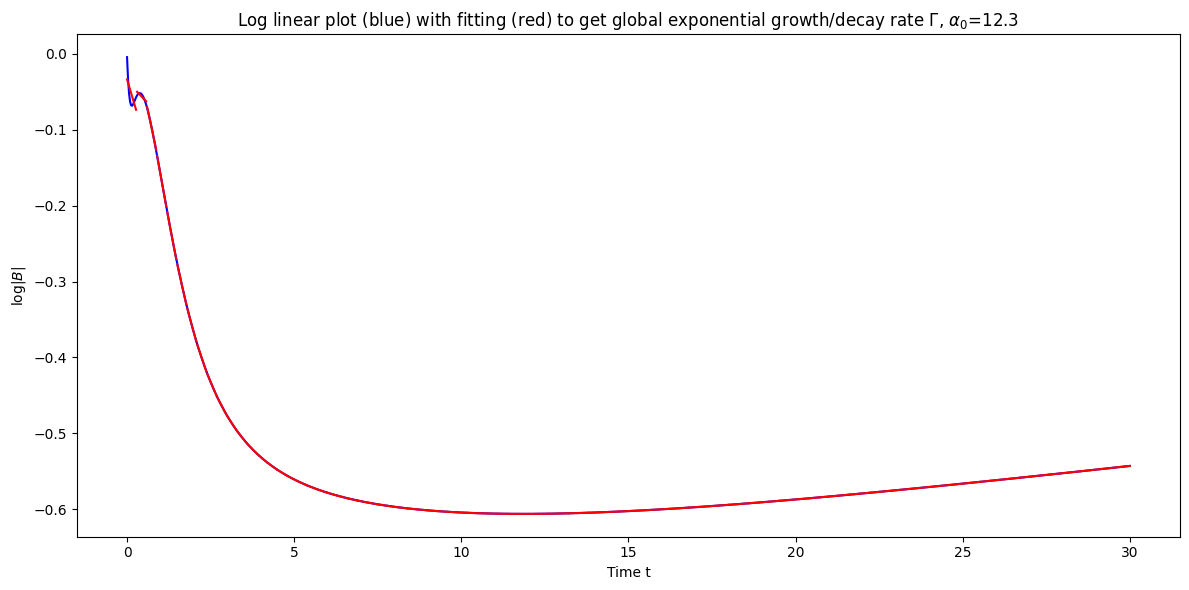

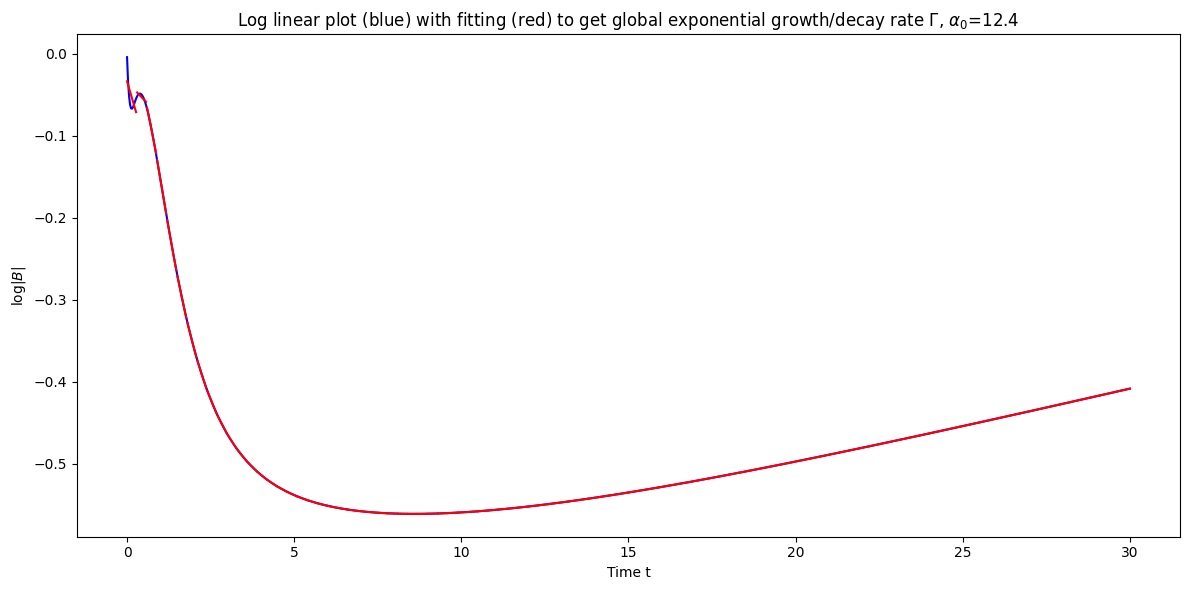

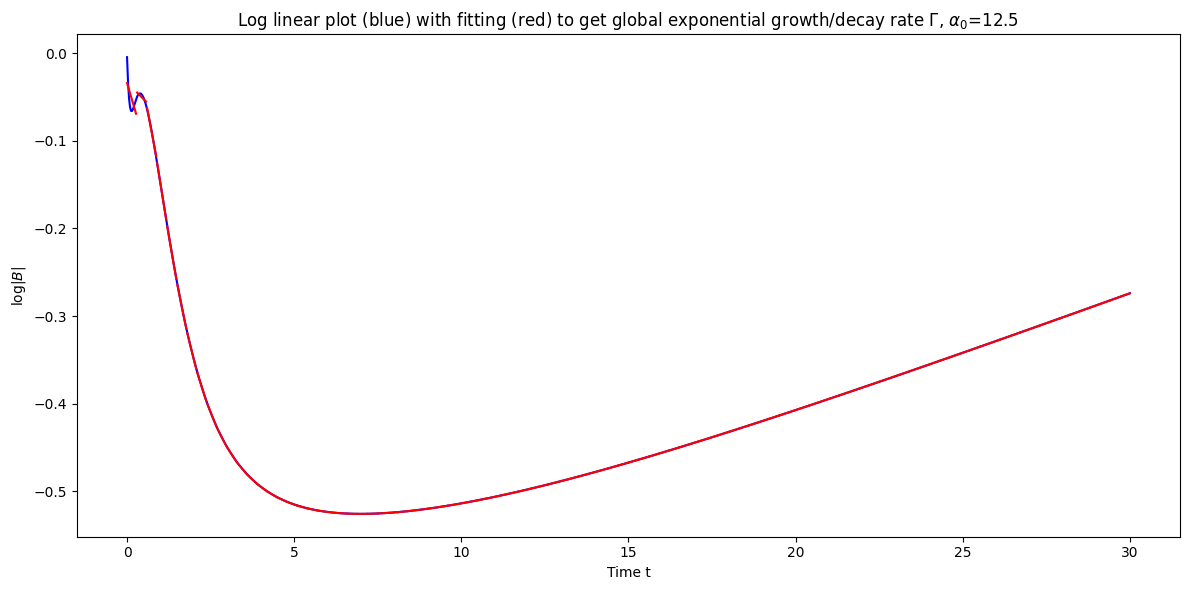

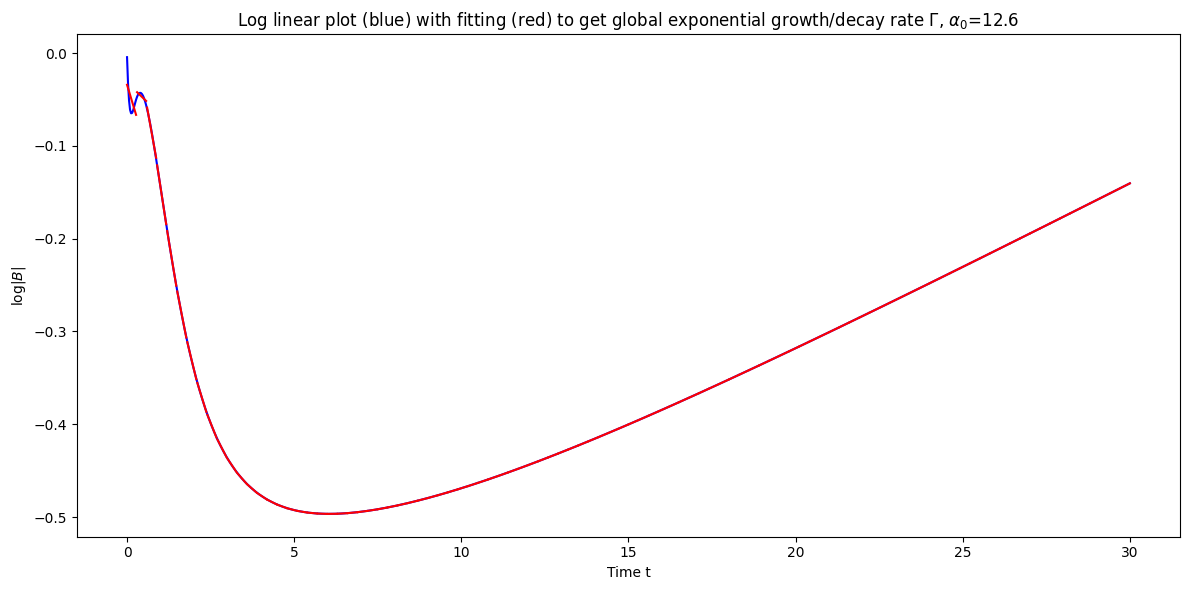

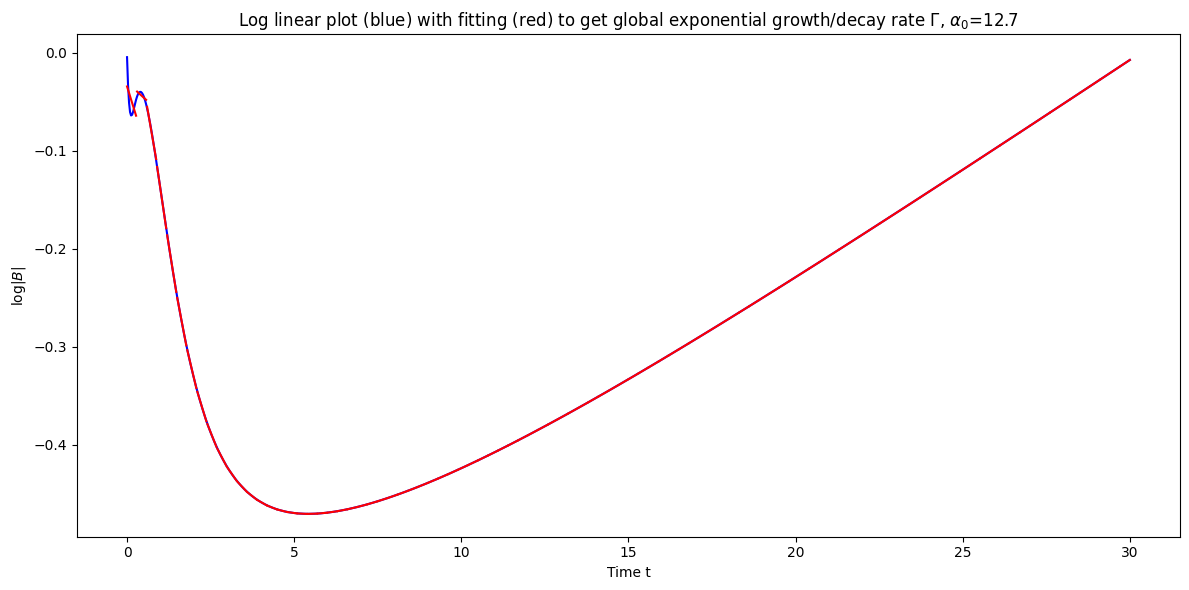

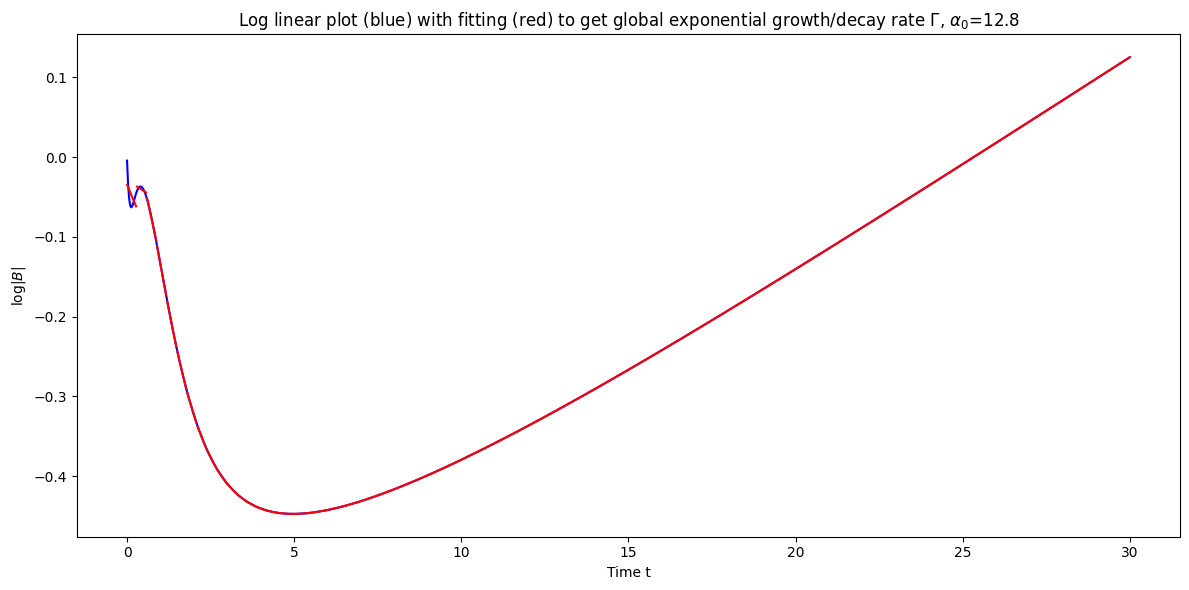

In [45]:
#Fit log|B| vs. t to a straight line piecewise, to find the global decay/growth rate Gamma (given by the slope at each piece)

slopes = np.zeros((len(alpha0),100))
for i in range(len(alpha0)):
    x = np.linspace(0, tmax, N_t)
    y = np.log10(np.abs(B_av_t[i, :]))
    for t in range(0,len(x),len(x)//100):
        # Fit a straight line to the data using numpy's polyfit() function
        fit = np.polyfit(x[t:t+10], y[t:t+10], 1)
        # Slope of the fitted line, gives Gamma
        slopes[i,t//10] = fit[0]/0.43429
        
#Plot log |B| vs. t for different alpha0, along with the fit straight lines
for i in range(len(alpha0)):
    plot.figure(figsize=(12, 6))
    plot.plot(np.linspace(0, tmax, N_t), np.log10(np.abs(B_av_t[i, :])), color='blue') #Original data
    #plot.legend([f'r={r[i]:.3f}' for i in range(2, len(r), len(r)//10)])
    x = np.linspace(0, tmax, N_t)
    y = np.log10(np.abs(B_av_t[i, :]))
    for t in range(0,len(x),len(x)//100):
        # Fit a straight line to the data using numpy's polyfit() function
        fit = np.polyfit(x[t:t+10], y[t:t+10], 1)
        # Generate y-values based on the fit
        y_fit = fit[0]*x + fit[1]
        plot.plot(x[t:t+10], y_fit[t:t+10], color='red') #Fit line
    #print(slopes)
    plot.xlabel('Time t')
    plot.ylabel(r'log$|B|$')
    plot.title(r"Log linear plot (blue) with fitting (red) to get global exponential growth/decay rate $\Gamma$, $\alpha_0$=" + str(alpha0[i]))
    plot.tight_layout()
    plot.show()

Gamma values for t (columns) for various alpha0 (rows): 
 [[-0.51955349 -0.18027003 -0.53396074 ... -0.07283337 -0.07279852
  -0.07276513]
 [-0.40850789 -0.13306723 -0.50015893 ... -0.0201194  -0.02008557
  -0.02005318]
 [-0.38639135 -0.12397553 -0.49351023 ... -0.00970747 -0.00967384
  -0.00964164]
 ...
 [-0.27634126 -0.08012587 -0.4607646  ...  0.04172689  0.04175956
   0.04179082]
 [-0.25444579 -0.07166147 -0.45430516 ...  0.05189219  0.05192467
   0.05195575]
 [-0.23259101 -0.06329373 -0.44787166 ...  0.06201807  0.06205037
   0.06208127]]


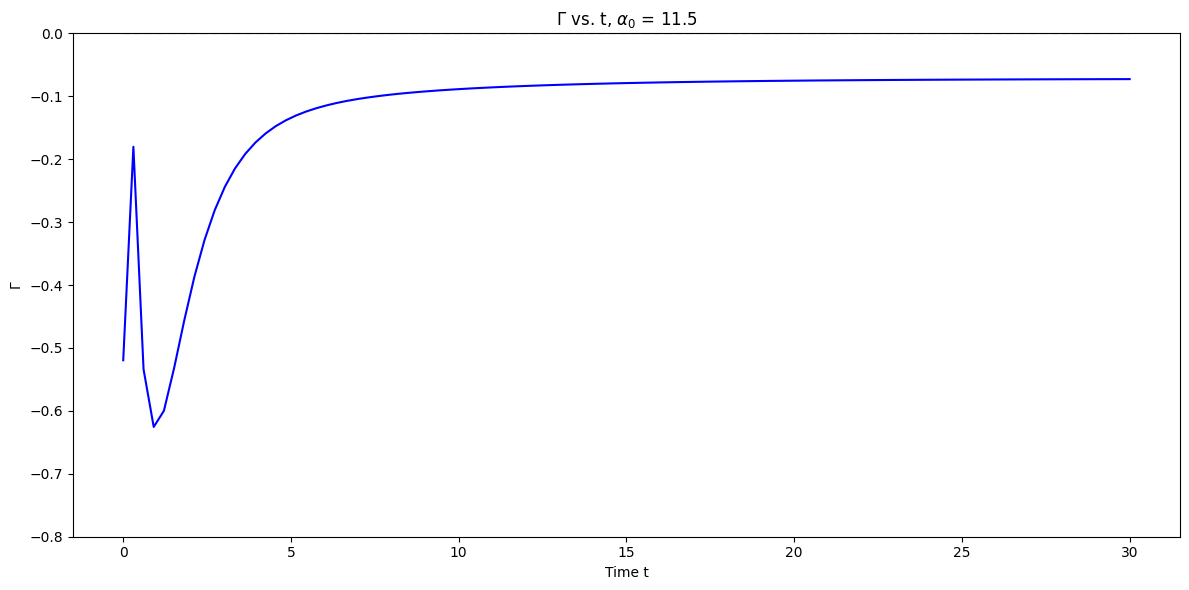

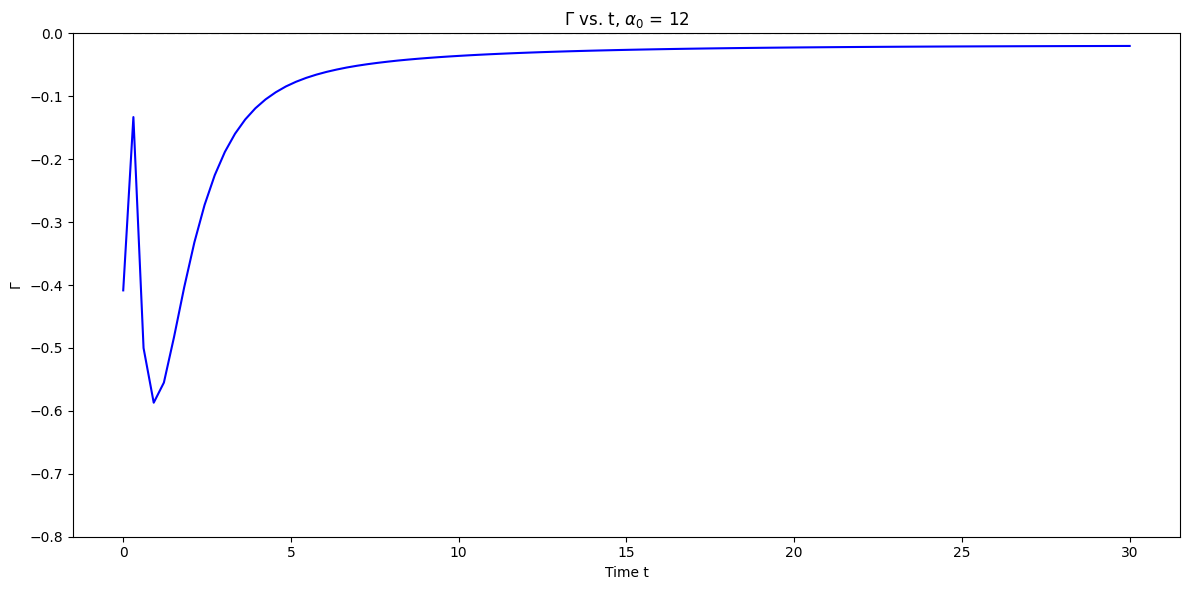

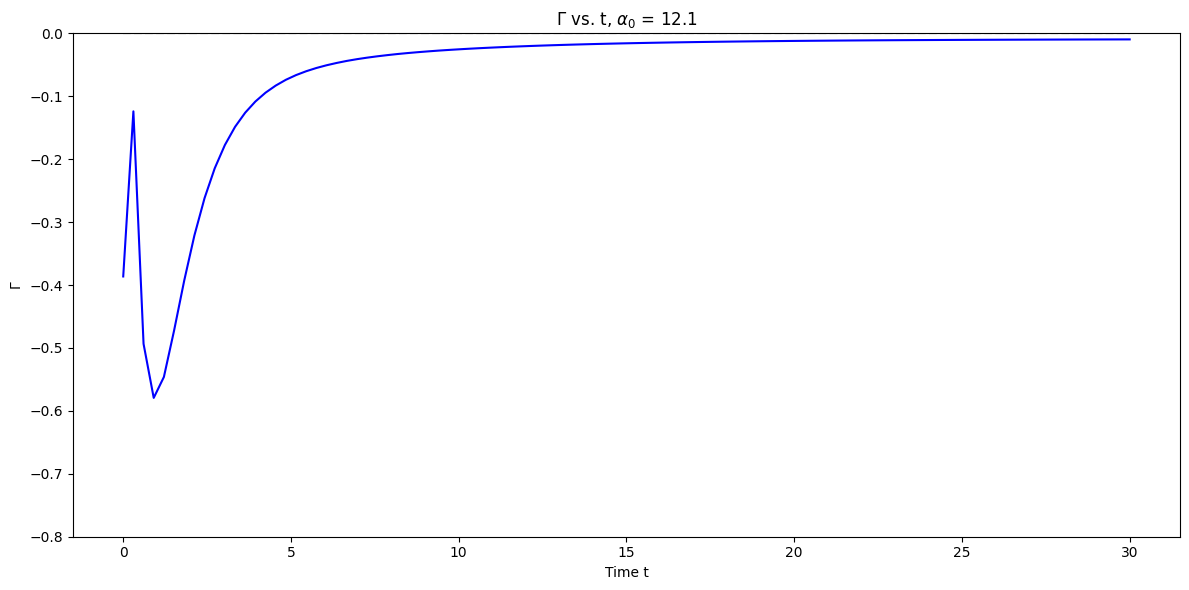

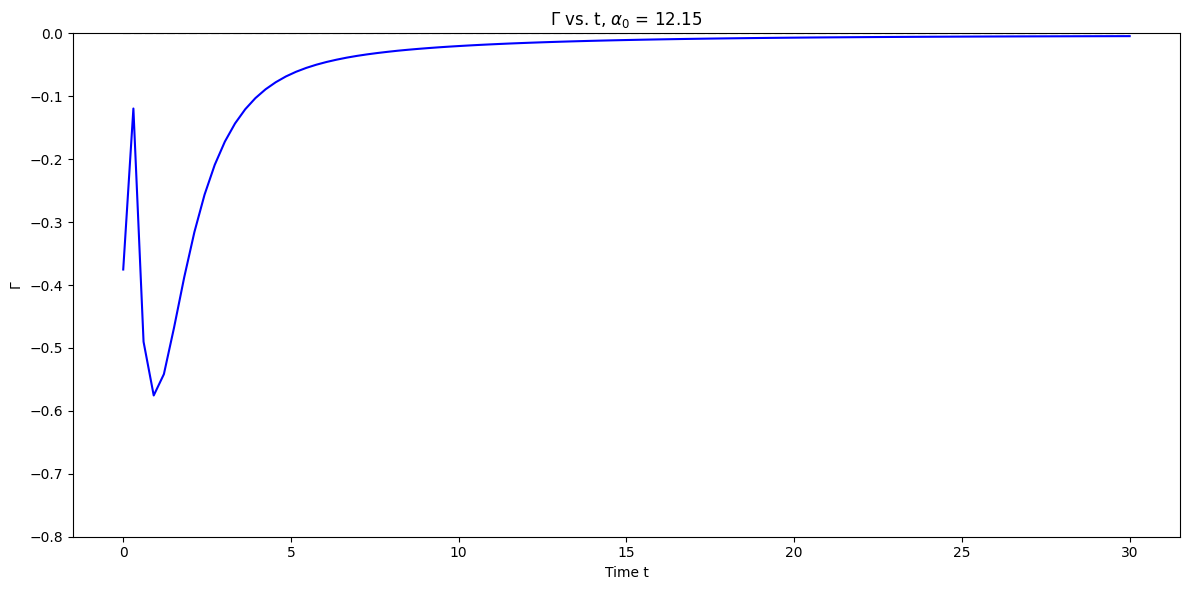

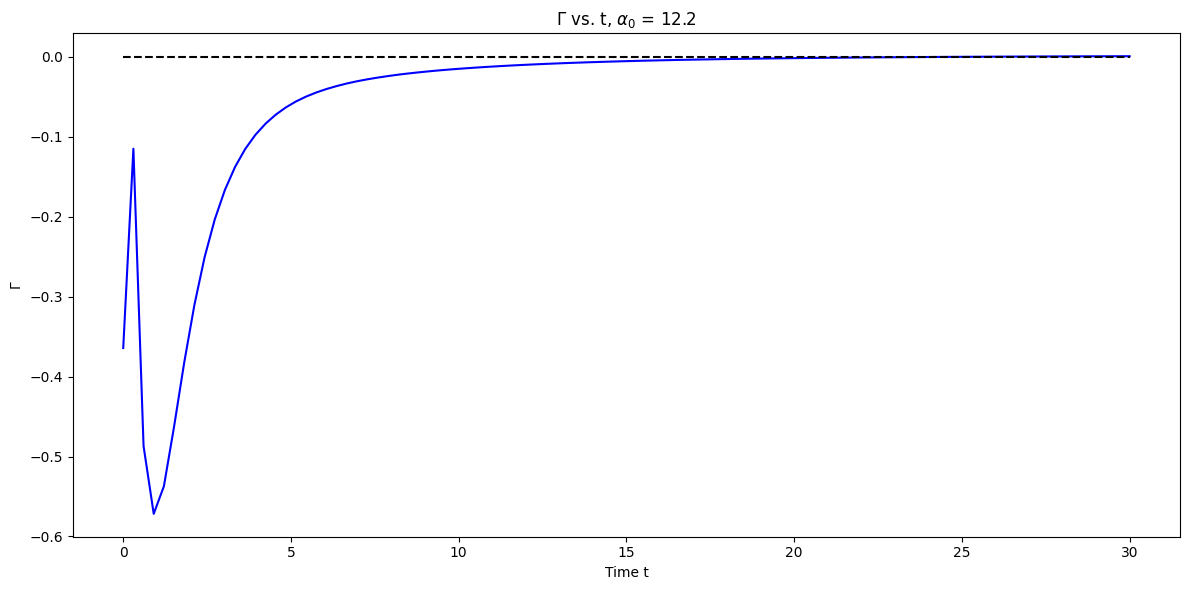

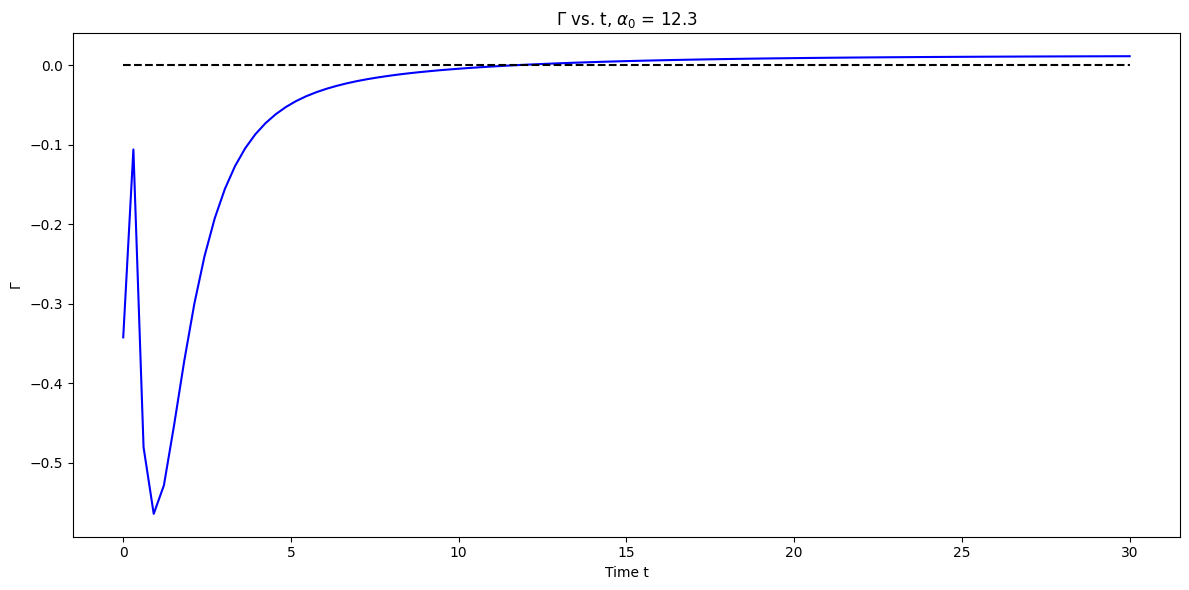

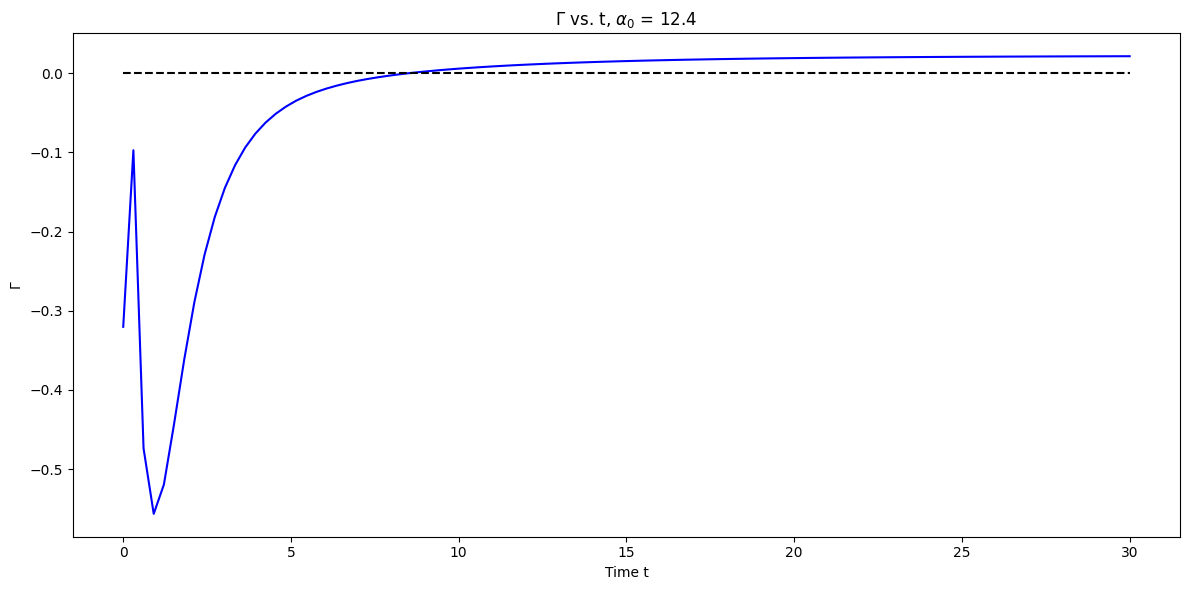

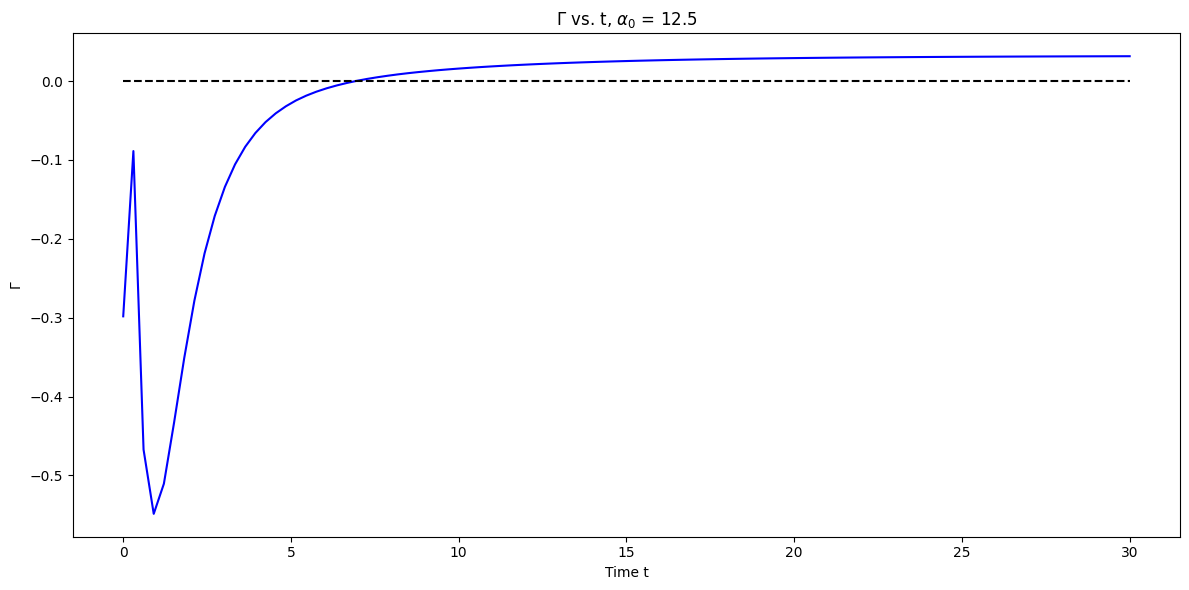

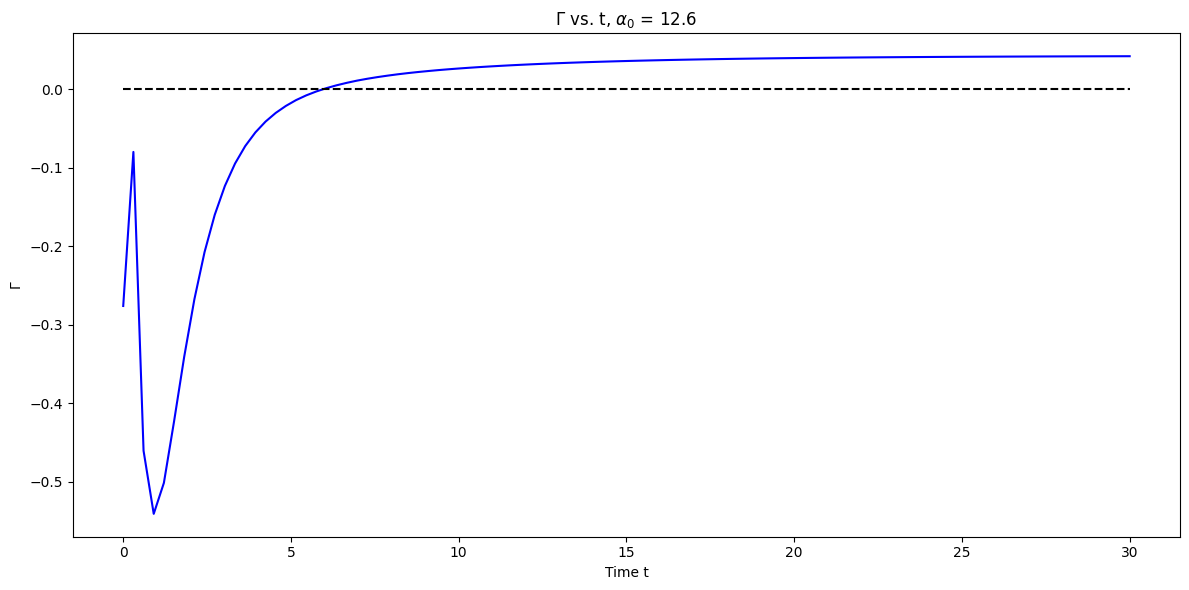

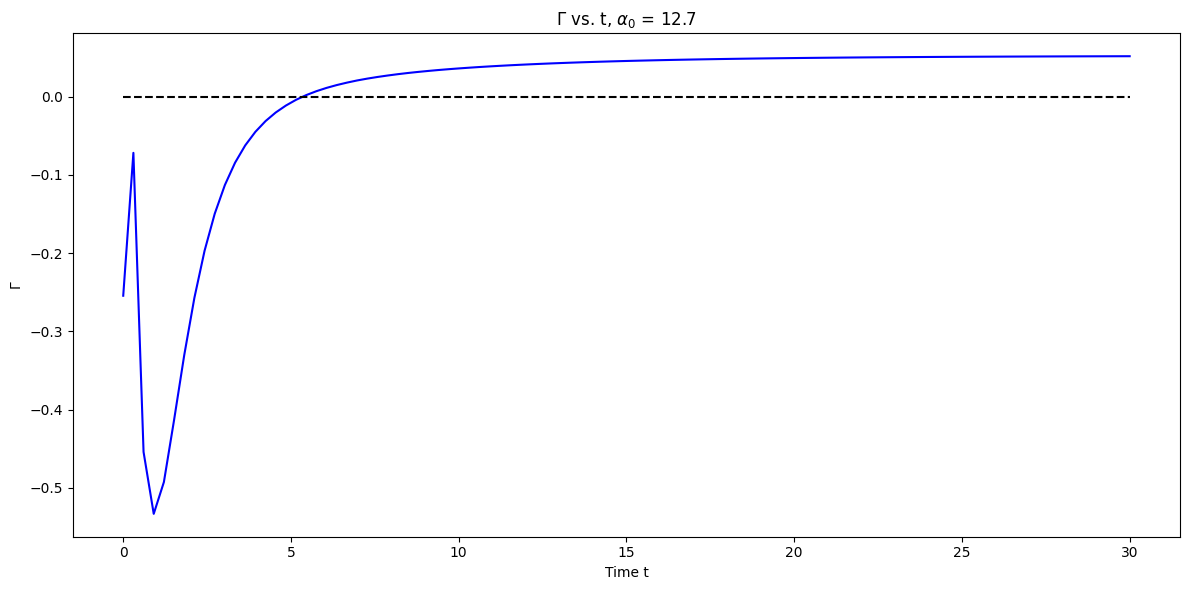

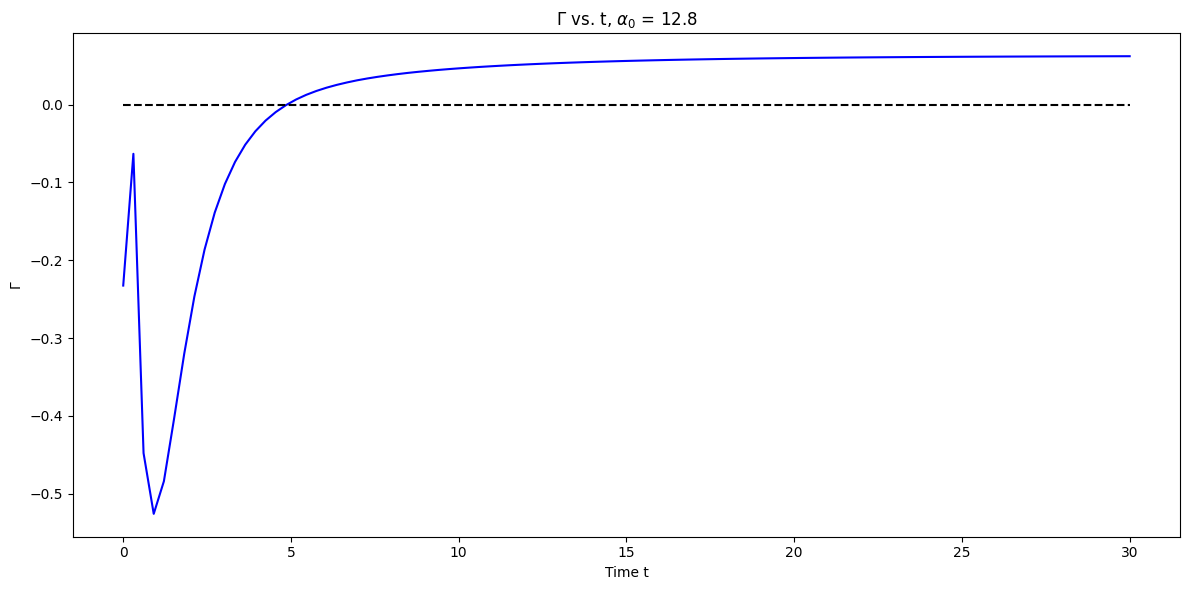

In [55]:
#Plot global growth/decay rate Gamma for all alpha0

print('Gamma values for t (columns) for various alpha0 (rows): \n',slopes)
for i in range(len(alpha0)):
    plot.figure(figsize=(12, 6))
    plot.plot(np.linspace(0, tmax, 100), slopes[i], color='blue')
    plot.plot(np.linspace(0, tmax, 100), np.zeros(100), color='black', linestyle='--')
    plot.xlabel('Time t')
    plot.ylabel(r'$\Gamma$')
    if alpha0[i]<12.2:
        plot.ylim(-0.8,0)
    plot.title(r"$\Gamma$ vs. t, $\alpha_0$ = "+str(alpha0[i]))
    plot.tight_layout()
    plot.show()

Initially, $\Gamma$ is negative, which corresponds to $|D| < |D_c|$. As $\alpha_0$ is increased, $\Gamma$ increases towards zero.

For $\alpha_0$ = 12.15, we can see the $\Gamma$ just touching zero, in the set timescale of 30. Thus, this $\alpha_0$ along with $\Omega_0$, gives the value of $|D_c|$. We see that it has changed from the case where the boundary condition was not applied, but not much.

Thus, in dimensionless units,


<div align="center">

$D_c$ = ${\alpha_0 \Omega_0}$ $r\frac{\partial \Omega}{\partial r}$ = $12.15 \times 5 \times r\frac{\partial \Omega}{\partial r} = 60.75$ $r\frac{\partial \Omega}{\partial r}$,

where $r\frac{\partial \Omega}{\partial r}$ corresponds to the rotation curve of the galaxy. As $r\frac{\partial \Omega}{\partial r}$ is negative, $D_c$ is negative as expected.

Final answer: 

$D_c = 60.75$ $r\frac{\partial \Omega}{\partial r}$

</div>


As $\alpha_0$ increases further, $\Gamma$ crosses zero, i.e. $|D|>|D_c|$.

Finally, plot the spatial evolution of $|B_r|$ and $|B_\phi|$, and the pitch angle p for different $\alpha_0$. We can see that the boundary conditions ensure the field is zero at $r=0$ and $r=R_0$.

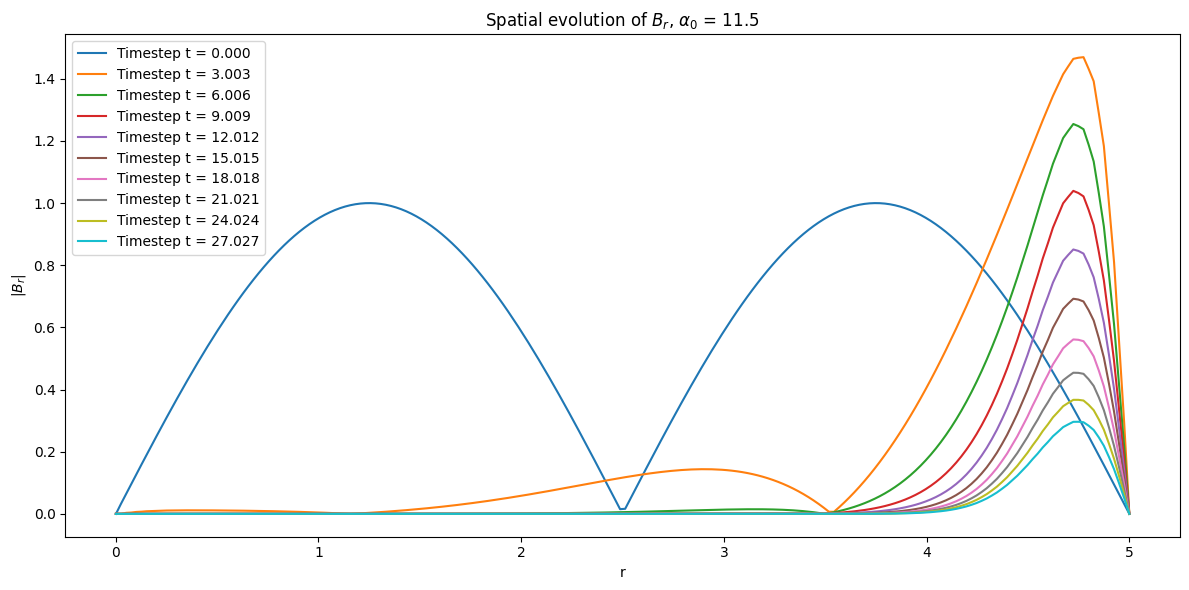

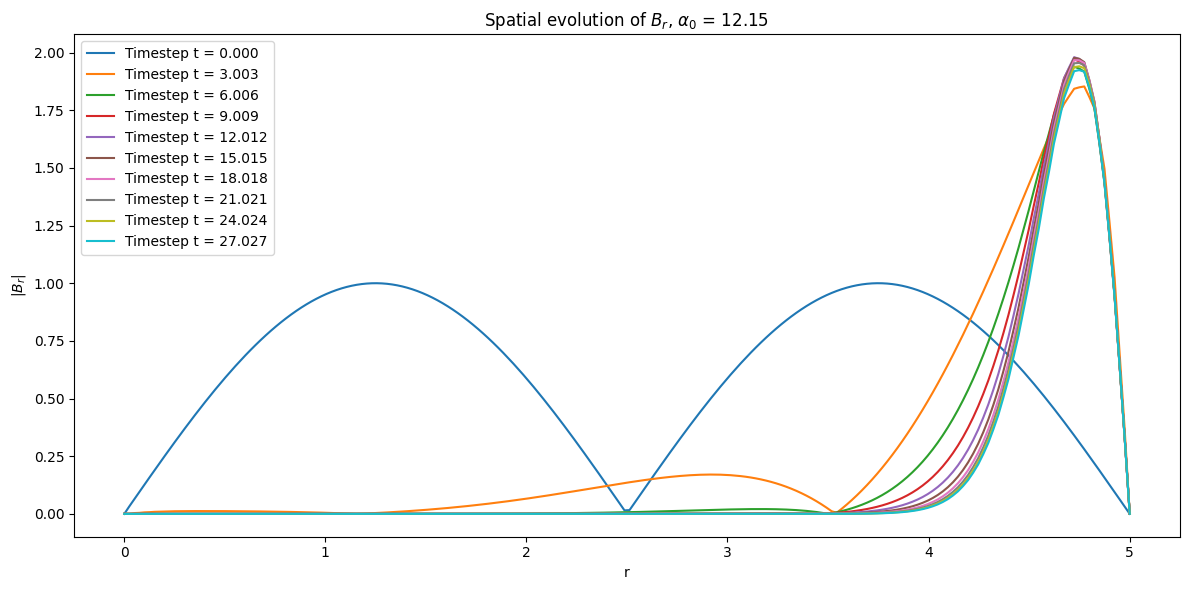

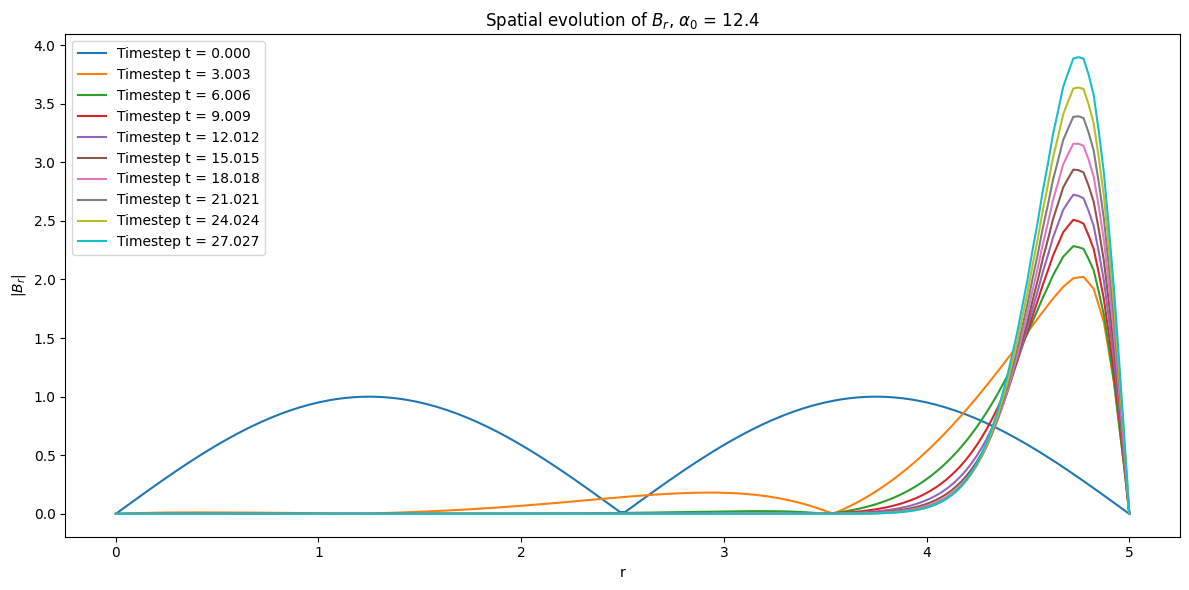

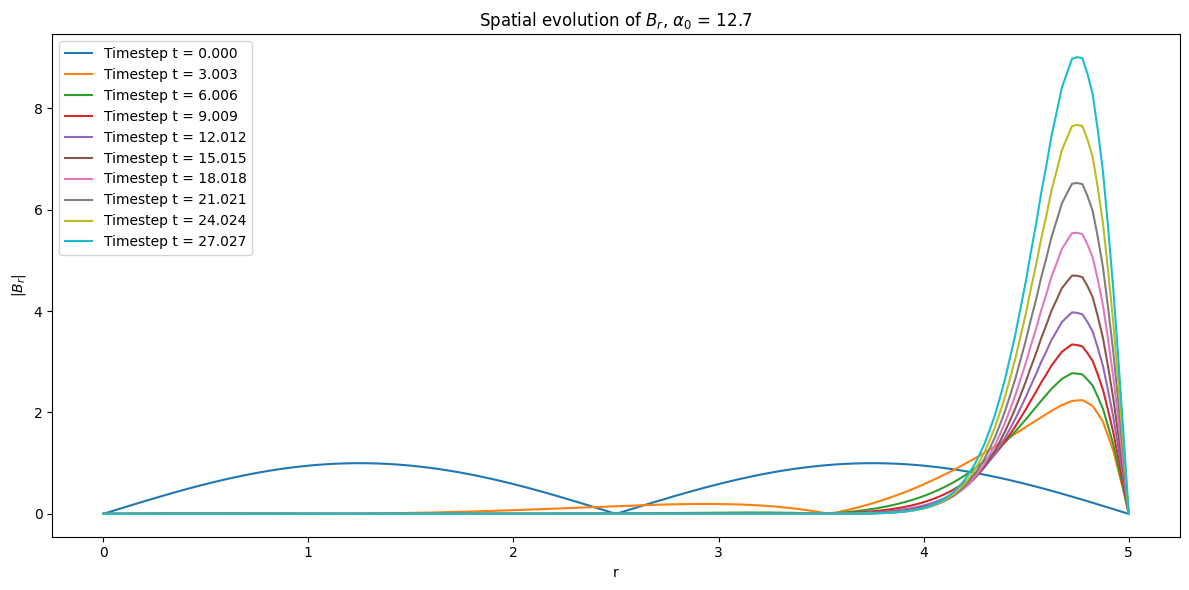

In [47]:
#Spatial evolution of B_r

for i in range(0,len(alpha0),len(alpha0)//3):
    tarray = np.linspace(0,tmax,N_t)
    plot.figure(figsize=(12, 6))
    plot.plot(r, np.abs(sol_array_Br[i,::len(tarray)//10, :].T))
    plot.legend([f'Timestep t = {tarray[i]:.3f}' for i in range(0,1000,100)])
    plot.xlabel('r')
    plot.ylabel(r'$|B_r|$')
    plot.title(r"Spatial evolution of $B_r$, $\alpha_0$ = " + str(alpha0[i]))
    #plot.xlim(0,1)
    #plot.ylim(0,.025)
    plot.tight_layout()
    plot.show()

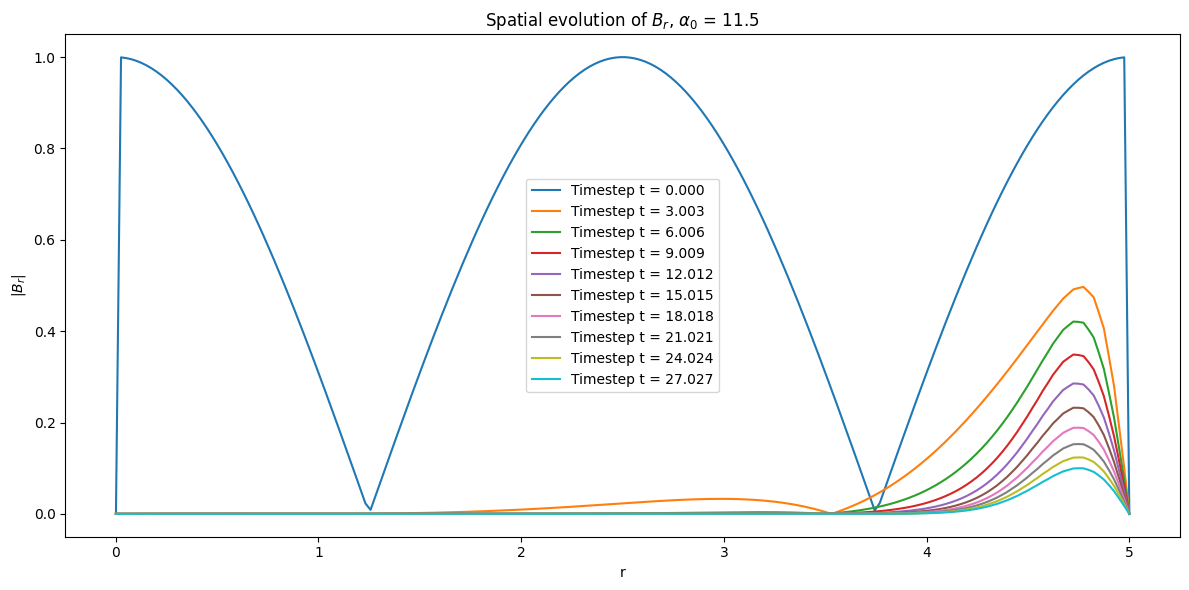

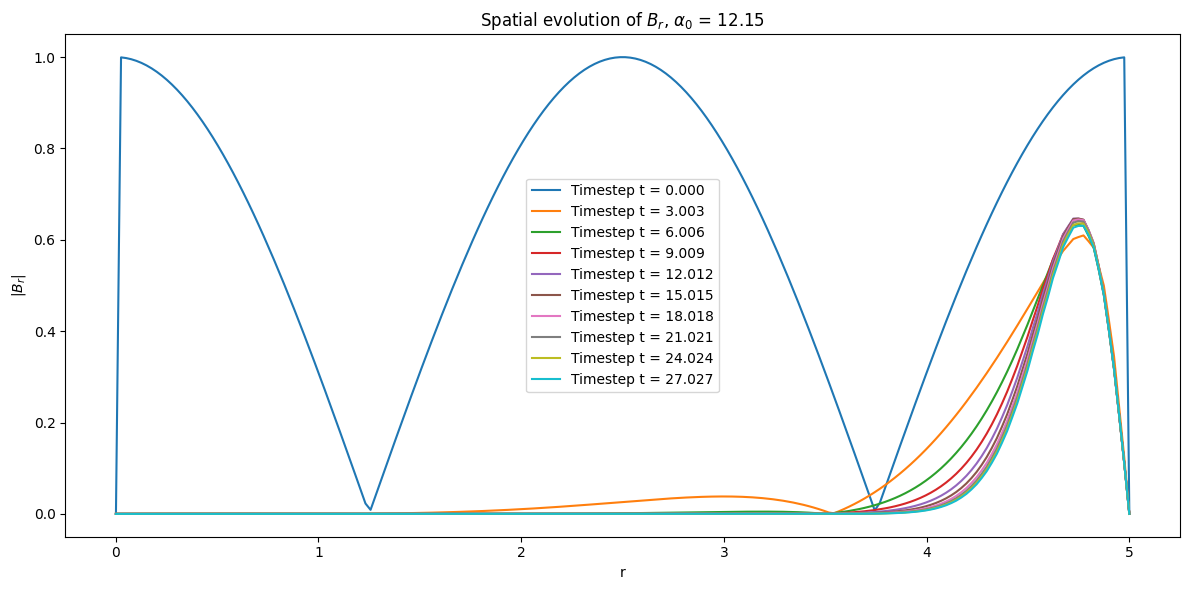

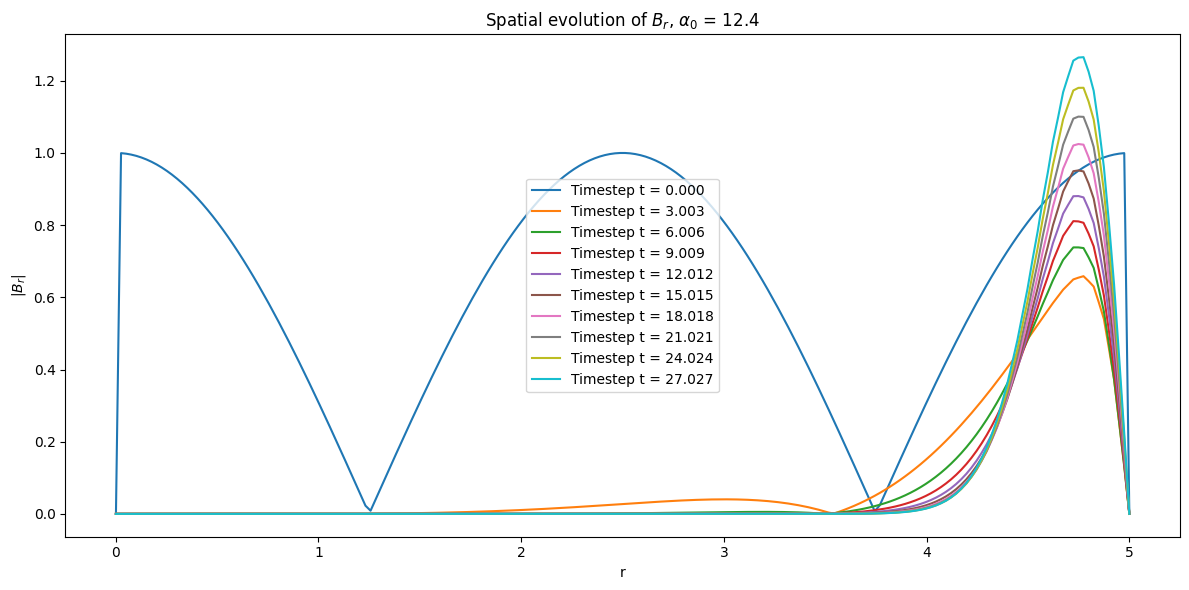

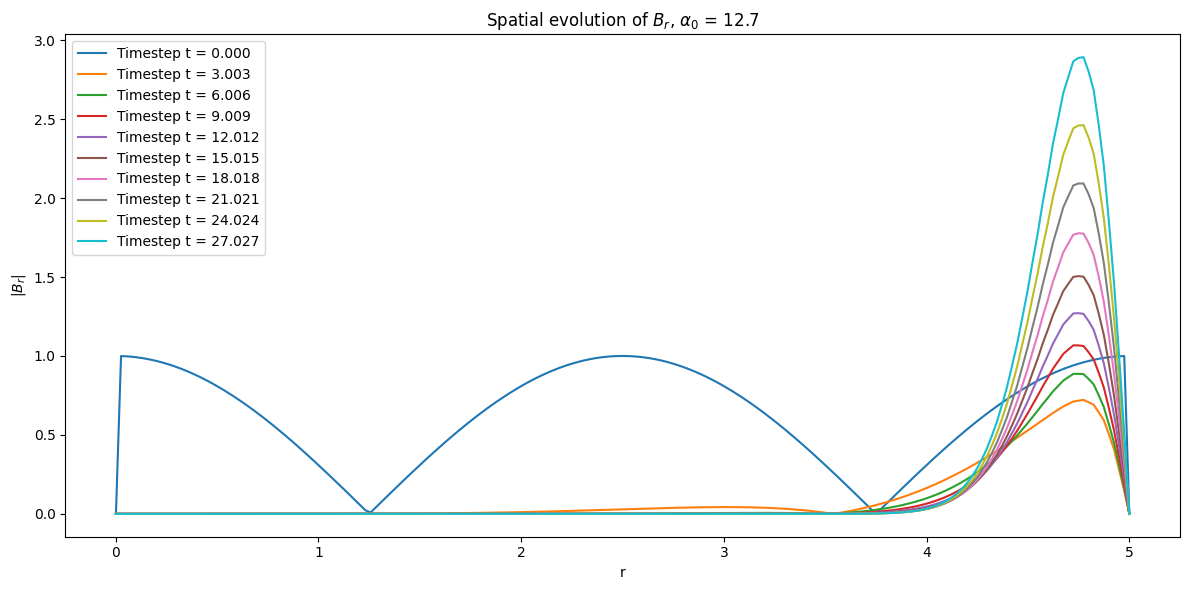

In [48]:
#Spatial evolution of B_phi

for i in range(0,len(alpha0),len(alpha0)//3):
    tarray = np.linspace(0,tmax,N_t)
    plot.figure(figsize=(12, 6))
    plot.plot(r, np.abs(sol_array_Bphi[i,::len(tarray)//10, :].T))
    plot.legend([f'Timestep t = {tarray[i]:.3f}' for i in range(0,1000,100)])
    plot.xlabel('r')
    plot.ylabel(r'$|B_r|$')
    plot.title(r"Spatial evolution of $B_r$, $\alpha_0$ = " + str(alpha0[i]))
    #plot.xlim(0,1)
    #plot.ylim(0,.025)
    plot.tight_layout()
    plot.show()

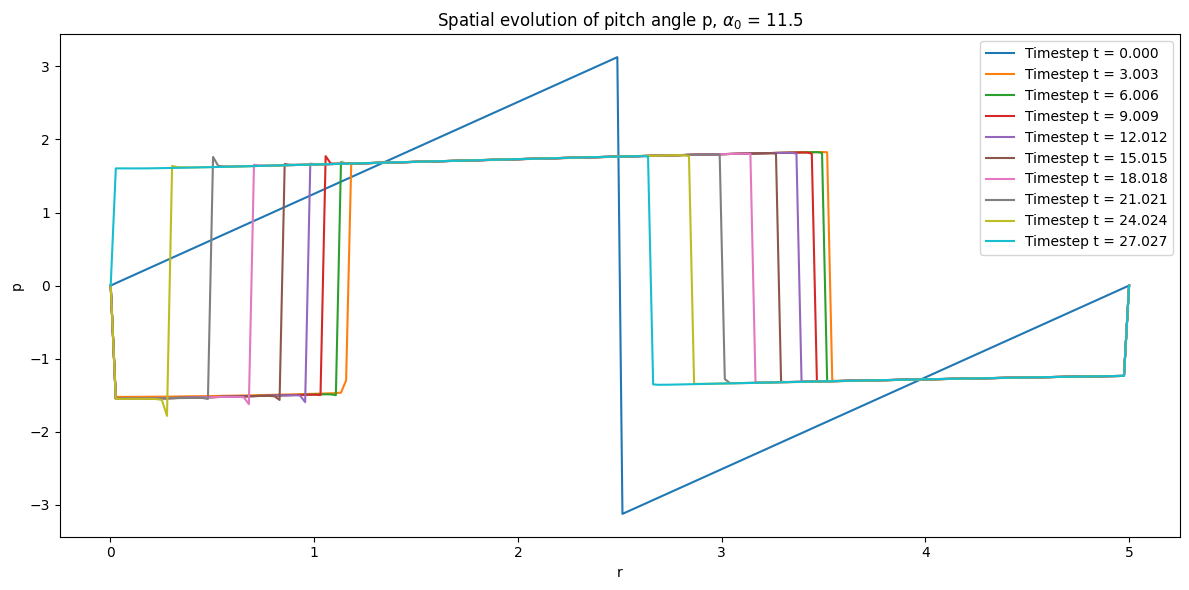

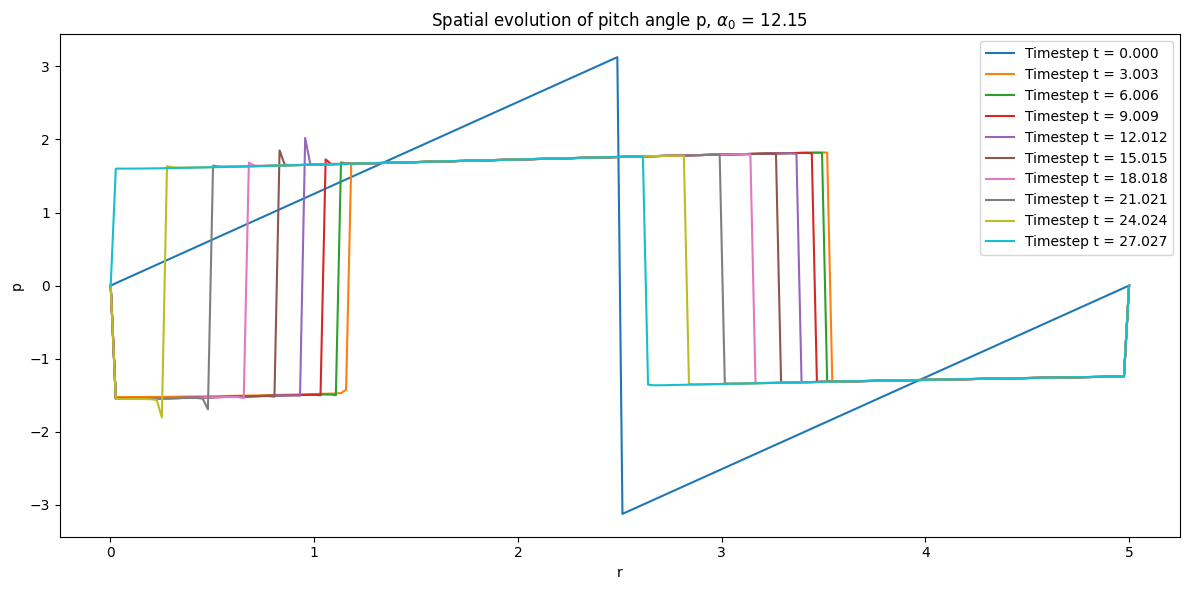

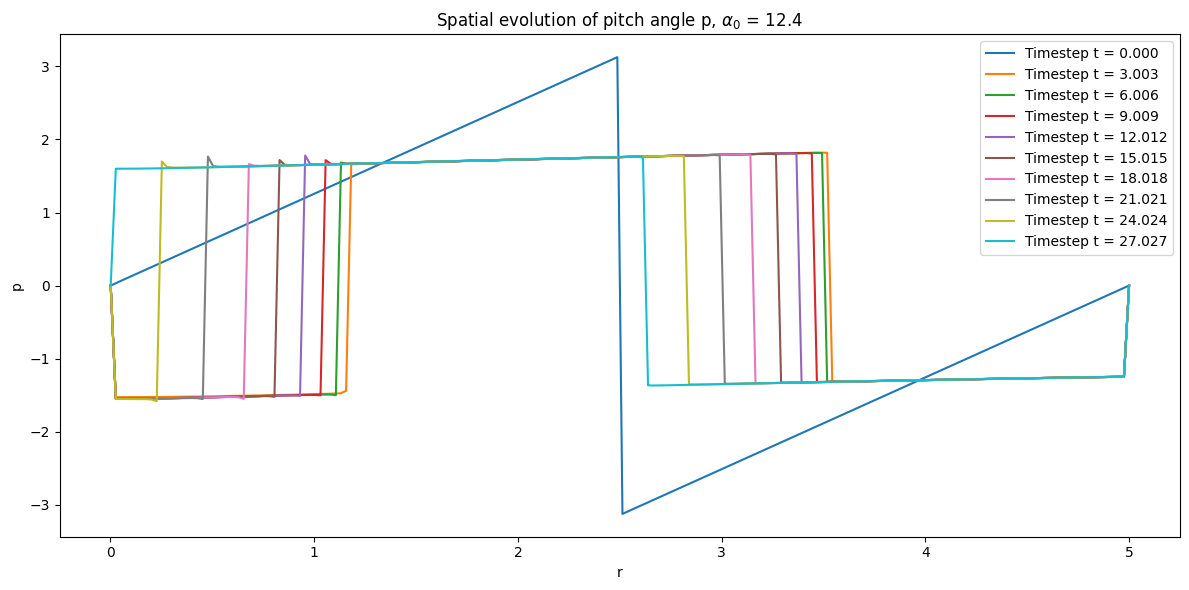

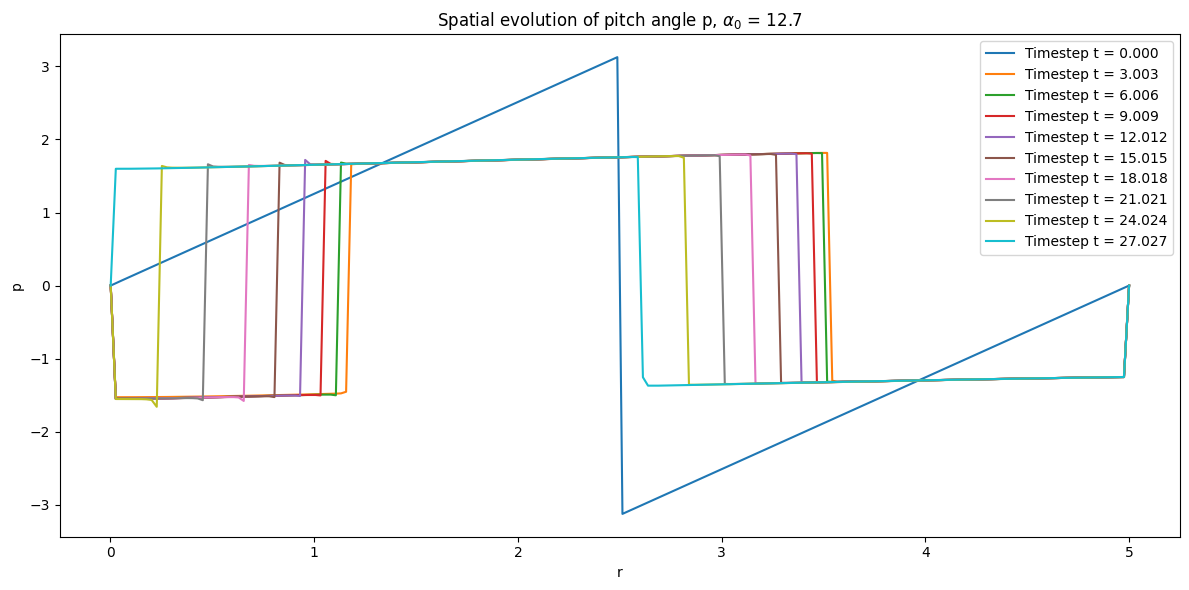

In [49]:
#Pitch Angle

for i in range(0,len(alpha0),len(alpha0)//3):
    plot.figure(figsize=(12, 6))
    plot.plot(r, np.arctan2(sol_array_Br[i,::len(tarray)//10, :].T,sol_array_Bphi[i,::len(tarray)//10, :].T))
    #plot.plot(np.linspace(0, tmax, N_t), np.abs(sol_array[:, [12,13,14,15,16]]))
    #plot.legend([f'r={r[i]:.3f}' for i in range(12,17)])
    plot.legend([f'Timestep t = {tarray[i]:.3f}' for i in range(0,1000,100)])
    plot.xlabel('r')
    plot.ylabel('p')
    plot.title(r"Spatial evolution of pitch angle p, $\alpha_0$ = "+f'{alpha0[i]}')
    #plot.xlim(0,5)
    #plot.ylim(0,.025)
    plot.tight_layout()
    plot.show()